In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import math
import random

# from keras.utils import to_categorical
# from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import set_random_seed
# from tensorflow.python.client import device_lib
import datetime as dt
import os
np.random.seed(7)
# set_random_seed(7)
from scipy.spatial import distance
from numpy.random import choice
import math
from scipy import stats
from scipy import optimize
# import seaborn as sns; sns.set()
from scipy import stats
from statsmodels.stats import contingency_tables

In [2]:
import matplotlib as mpl

mpl.use('svg')
new_rc_params = {
    "font.size": 20, #choosing the font size helps latex to place all the labels, ticks etc. in the right place
    "svg.fonttype": 'none',
    'figure.max_open_warning': 0
} 

mpl.rcParams.update(new_rc_params)
#     "font.weight":700
plt.rcParams['axes.facecolor'] = (1, 1.0, 1, 1)
plt.rcParams['figure.facecolor'] = (1.0, 1, 1, 1.0)
plt.rcParams['savefig.facecolor'] = (1, 1.0, 1.0, 1)

my_font_dict = {
        'size': 20,
        }

In [3]:
def color_axes(axes_):
    axes_.spines['bottom'].set_color('black')
    axes_.spines['top'].set_color('black') 
    axes_.spines['right'].set_color('black')
    axes_.spines['left'].set_color('black')
    axes_.grid(color='black', linestyle='-', linewidth=0.3)

In [4]:
#12.8.20
# saving_dir = 'explain/one_stop_shop/'
# if not os.path.exists(saving_dir):
#     os.makedirs(saving_dir)

# 1.11.21 + 16.2.22
saving_dir = 'explain/one_stop_shop/updated_qlearning_paper_addition/feb_2022/'
if not os.path.exists(saving_dir):
    os.makedirs(saving_dir)
    
# # 1.11.21
# saving_dir = 'explain/one_stop_shop/new_scatterplot_paper_addition/'
# if not os.path.exists(saving_dir):
#     os.makedirs(saving_dir)

In [5]:
# generated_data = pd.read_csv(os.path.join('explain/','generated_data.csv'))

In [6]:
data = pd.read_csv('DataAllSubjectsRewards.csv')
data.fillna(-1, inplace=True)

## prior results

In [7]:
general_saving_dir = "cross_validation/averages/general/"
if not os.path.exists(general_saving_dir):
    os.makedirs(general_saving_dir)
    
# reward_oriented_saving_dir = "cross_validation/averages/reward_oriented/"
# if not os.path.exists(reward_oriented_saving_dir):
#     os.makedirs(reward_oriented_saving_dir)
    
no_reward_saving_dir = "cross_validation/averages/no_reward/"
if not os.path.exists(no_reward_saving_dir):
    os.makedirs(no_reward_saving_dir)

In [8]:
# load the kfolded pars
with open('cross_validation/payoff2_train_participants_5fold_list.pkl', 'rb') as f:
    payoff2_train_participants_5fold_list = pickle.load(f)

with open('cross_validation/payoff2_test_participants_5fold_list.pkl', 'rb') as f:
    payoff2_test_participants_5fold_list = pickle.load(f)

with open('cross_validation/payoff3_train_participants_5fold_list.pkl', 'rb') as f:
    payoff3_train_participants_5fold_list = pickle.load(f)

with open('cross_validation/payoff3_test_participants_5fold_list.pkl', 'rb') as f:
    payoff3_test_participants_5fold_list = pickle.load(f)

with open('cross_validation/payoff4_train_participants_5fold_list.pkl', 'rb') as f:
    payoff4_train_participants_5fold_list = pickle.load(f)

with open('cross_validation/payoff4_test_participants_5fold_list.pkl', 'rb') as f:
    payoff4_test_participants_5fold_list = pickle.load(f)

In [73]:
# general
with open(os.path.join(general_saving_dir, 'general_all_folds_all_payoffs_true_false.pkl'), 'rb') as f:
    general_all_folds_all_payoffs_true_false = pickle.load(f)
general_all_folds_true_false, general_payoff2_persons_true_false_predictions_lstm, general_payoff3_persons_true_false_predictions_lstm, general_payoff4_persons_true_false_predictions_lstm = general_all_folds_all_payoffs_true_false

with open(os.path.join(general_saving_dir, 'general_all_accuracy_per_par.pkl'), 'rb') as f:
    general_all_accuracy_per_par = pickle.load(f)
general_all_folds_lstm_accs, general_payoff2_lstm_accs, general_payoff3_lstm_accs, general_payoff4_lstm_accs = general_all_accuracy_per_par


# reward_oriented - not needed at the momement
# with open(os.path.join(reward_oriented_saving_dir, 'reward_oriented_all_folds_all_payoffs_true_false.pkl'), 'rb') as f:
#     reward_oriented_all_folds_all_payoffs_true_false = pickle.load(f)
# reward_oriented_all_folds_true_false, reward_oriented_payoff2_persons_true_false_predictions_lstm, reward_oriented_payoff3_persons_true_false_predictions_lstm, reward_oriented_payoff4_persons_true_false_predictions_lstm = reward_oriented_all_folds_all_payoffs_true_false

# with open(os.path.join(reward_oriented_saving_dir, 'reward_oriented_all_accuracy_per_par.pkl'), 'rb') as f:
#     reward_oriented_all_accuracy_per_par = pickle.load(f)
# reward_oriented_all_folds_lstm_accs, reward_oriented_payoff2_lstm_accs, reward_oriented_payoff3_lstm_accs, reward_oriented_payoff4_lstm_accs = reward_oriented_all_accuracy_per_par


# no_reward
with open(os.path.join(no_reward_saving_dir, 'no_reward_all_folds_all_payoffs_true_false.pkl'), 'rb') as f:
    no_reward_all_folds_all_payoffs_true_false = pickle.load(f)
no_reward_all_folds_true_false, no_reward_payoff2_persons_true_false_predictions_lstm, no_reward_payoff3_persons_true_false_predictions_lstm, no_reward_payoff4_persons_true_false_predictions_lstm = no_reward_all_folds_all_payoffs_true_false

with open(os.path.join(no_reward_saving_dir, 'no_reward_all_accuracy_per_par.pkl'), 'rb') as f:
    no_reward_all_accuracy_per_par = pickle.load(f)
no_reward_all_folds_lstm_accs, no_reward_payoff2_lstm_accs, no_reward_payoff3_lstm_accs, no_reward_payoff4_lstm_accs = no_reward_all_accuracy_per_par

In [9]:
full_orig_data = pd.read_csv('DataAllSubjectsRewards.csv')

In [52]:
data_filled_NA = data
# data_noNA = full_orig_data.dropna()
# notice that here is where I choose if feeding full data with blanks, or without blanks
# without blanks:
# data_payoff2 = data_noNA[data_noNA['payoff_structure']==2]
# data_payoff3 = data_noNA[data_noNA['payoff_structure']==3]
# data_payoff4 = data_noNA[data_noNA['payoff_structure']==4]
# with blanks:
data_payoff2 = data_filled_NA[data_filled_NA['payoff_structure']==2]
data_payoff3 = data_filled_NA[data_filled_NA['payoff_structure']==3]
data_payoff4 = data_filled_NA[data_filled_NA['payoff_structure']==4]
user_ids2 = data_payoff2.user.unique()
user_ids3 = data_payoff3.user.unique()
user_ids4 = data_payoff4.user.unique()

In [11]:
os.getcwd()

'C:\\Users\\User\\ML\\Thesis'

load qlearning related data <a id='load_reward_oriented'></a>

In [13]:
# loading_dir = 'explain/qlearning_model_plots/'
# with open(os.path.join(loading_dir,'payoff2_qlearn_reproduce_tf.pkl'), 'rb') as handle:
#     payoff2_qlearn_plots_res = pickle.load(handle)

    
# with open(os.path.join(loading_dir,'payoff3_qlearn_reproduce_tf.pkl'), 'rb') as handle:
#     payoff3_qlearn_plots_res = pickle.load(handle)

# with open(os.path.join(loading_dir,'payoff4_qlearn_reproduce_tf.pkl'), 'rb') as handle:
#     payoff4_qlearn_plots_res = pickle.load(handle)


# # 3.10.20 fixed version
# with open('explain/qlearning_model_plots/cross_validation/fixed/payoff2_qlearn_reproduce_fixed.pkl', 'rb') as handle:
#     payoff2_qlearn_plots_res = pickle.load(handle)

    
# with open('explain/qlearning_model_plots/cross_validation/fixed/payoff3_qlearn_reproduce_fixed.pkl', 'rb') as handle:
#     payoff3_qlearn_plots_res = pickle.load(handle)

# with open('explain/qlearning_model_plots/cross_validation/fixed/payoff4_qlearn_reproduce_fixed.pkl', 'rb') as handle:
#     payoff4_qlearn_plots_res = pickle.load(handle)

    
# payoff_2_person_features, payoff_2_person_accuracies, payoff_2_person_real_accuracies, payoff_2_person_predictions, payoff_2_person_true_false_predictions_matrix_qlearning = payoff2_qlearn_plots_res
# payoff_3_person_features, payoff_3_person_accuracies, payoff_3_person_real_accuracies, payoff_3_person_predictions, payoff_3_person_true_false_predictions_matrix_qlearning = payoff3_qlearn_plots_res 
# payoff_4_person_features, payoff_4_person_accuracies, payoff_4_person_real_accuracies, payoff_4_person_predictions, payoff_4_person_true_false_predictions_matrix_qlearning = payoff4_qlearn_plots_res 

# 1.1.21 fixed version for paper addition -- ran it on the mac with os.path.join(os.getcwd(), 'paper_additions') so might need to change this path
macbook_saving_dir = os.path.join(os.getcwd(), 'paper_additions')

with open(os.path.join(macbook_saving_dir, 'payoff2_qlearn_reproduce_fixed_paper.pkl'), 'rb') as handle:
    payoff2_qlearn_plots_res = pickle.load(handle)

    
with open(os.path.join(macbook_saving_dir, 'payoff3_qlearn_reproduce_fixed_paper.pkl'), 'rb') as handle:
    payoff3_qlearn_plots_res = pickle.load(handle)

with open(os.path.join(macbook_saving_dir, 'payoff4_qlearn_reproduce_fixed_paper.pkl'), 'rb') as handle:
    payoff4_qlearn_plots_res = pickle.load(handle)
    
qlearning_payoff_2_person_features, qlearning_payoff_2_person_accuracies, qlearning_payoff_2_person_real_accuracies, qlearning_payoff_2_person_predictions, payoff_2_person_true_false_predictions_matrix_qlearning = payoff2_qlearn_plots_res
qlearning_payoff_3_person_features, qlearning_payoff_3_person_accuracies, qlearning_payoff_3_person_real_accuracies, qlearning_payoff_3_person_predictions, payoff_3_person_true_false_predictions_matrix_qlearning = payoff3_qlearn_plots_res 
qlearning_payoff_4_person_features, qlearning_payoff_4_person_accuracies, qlearning_payoff_4_person_real_accuracies, qlearning_payoff_4_person_predictions, payoff_4_person_true_false_predictions_matrix_qlearning = payoff4_qlearn_plots_res 

In [48]:
qlearning_payoff_2_person_features

[[0.5302013422818792,
  61.5,
  6.2724736644903265,
  0.7596450790366824,
  148.6988425799381],
 [0.6308724832214765,
  63.70666666666666,
  6.2724736644903265,
  0.7596450790366824,
  137.69119422096483],
 [0.42953020134228187,
  61.32666666666667,
  6.2724736644903265,
  0.7596450790366824,
  150.8586490247395],
 [0.7046979865771812,
  63.266666666666666,
  6.2724736644903265,
  0.7596450790366824,
  126.12863387756582],
 [0.9060402684563759,
  55.92,
  6.2724736644903265,
  0.7596450790366824,
  203.33516930214114],
 [0.6577181208053692,
  63.31333333333333,
  6.2724736644903265,
  0.7596450790366824,
  134.84641502292658],
 [0.697986577181208,
  63.20666666666666,
  6.2724736644903265,
  0.7596450790366824,
  123.83542082678632],
 [0.6174496644295302,
  61.626666666666665,
  6.2724736644903265,
  0.7596450790366824,
  130.7376893662966],
 [0.7248322147651006,
  65.06666666666666,
  6.2724736644903265,
  0.7596450790366824,
  118.56489546742984],
 [0.8053691275167785,
  65.673333333

In [12]:
def get_avg_acc_per_time(payoff_person_true_false_predictions_matrix):
    """
    gets a payoff_person_true_false_predictions_matrix -  which can be either qlearning or lstm 
    return a vector of 150, each entrance is the avg accuracy across all participants in that payoff
    """
    payoff_all_pars_avg_acc_per_time = []
    for t in range(payoff_person_true_false_predictions_matrix.shape[1]):
        collect_not_minuses = []
        for pred in payoff_person_true_false_predictions_matrix[:,t]:
            if pred<0:
                continue
            else:
                collect_not_minuses.append(pred)
        payoff_all_pars_avg_acc_per_time.append(np.mean(collect_not_minuses))
    
    return payoff_all_pars_avg_acc_per_time

In [13]:
# def plot_accuracy_over_time(true_false_predictions_matrix_qlearning, true_false_predictions_matrix_lstm, payoff, legend_1='Qlearning acc', legend_2='LSTM acc', save_fig=False, add_text=""):
#     """
#     Ploting accuracy comparison over time between 2 models
#     """
#     plt.clf()
#     fig = plt.gcf()
#     fig.set_size_inches(15, 5)
#     x = np.arange(4,150)
#     plt.plot(x, get_avg_acc_per_time(true_false_predictions_matrix_qlearning)[4:], 'r') 
#     plt.plot(x, get_avg_acc_per_time(true_false_predictions_matrix_lstm)[4:], 'b') 
#     plt.legend([legend_1, legend_2])
#     plt.title('Payoff{} accuracy over time Qlearn vs LSTM'.format(payoff), fontdict=my_font_dict)
#     plt.xlabel('Time', fontdict=my_font_dict)
#     plt.ylabel('Accuracy', fontdict=my_font_dict)
#     plt.tick_params(axis='both', labelsize=20)
#     if save_fig:
#         fig.savefig(os.path.join(saving_dir,'payoff{}_accuracy_over_time_{}_Qlearn_vs_LSTM.svg'.format(payoff, add_text)), dpi=200, format='svg')
#     plt.show()

    
# plot_accuracy_over_time(payoff_2_person_true_false_predictions_matrix_qlearning, general_payoff2_persons_true_false_predictions_lstm, payoff=2, save_fig=True)
# plot_accuracy_over_time(payoff_3_person_true_false_predictions_matrix_qlearning, general_payoff3_persons_true_false_predictions_lstm, payoff=3, save_fig=True)
# plot_accuracy_over_time(payoff_4_person_true_false_predictions_matrix_qlearning, general_payoff4_persons_true_false_predictions_lstm, payoff=4, save_fig=True)

In [14]:
def plot_accuracy_over_time_all_together(true_false_pred_list:list, payoff:int, legend:list, save_fig=False, add_text=""):
    """
    Ploting accuracy comparison over time between (2) models
    """
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(22, 8)
    x = np.arange(4,150)
    colors = ['r','g','b']
    for pred_mat,color in zip(true_false_pred_list, colors):
        plt.plot(x, get_avg_acc_per_time(pred_mat)[4:], color) 
    
    plt.legend([l for l in legend])
    plt.title('payoff{}_accuracy_over_time_Qlearn_vs_LSTM'.format(payoff))
    plt.xlabel('time')
    plt.ylabel('accuracy')
    if save_fig:
        fig.savefig(os.path.join(saving_dir,'payoff{}_accuracy_over_time_{}_Qlearn_vs_LSTM.svg'.format(payoff, add_text)), dpi=200, format='svg')
    plt.show()

In [15]:
# # divide General lstm true/false matrix to payoffs
# payoff2_persons_true_false_predictions_lstm = np.asmatrix(persons_true_false_predictions[0:329])
# payoff3_persons_true_false_predictions_lstm = np.asmatrix(persons_true_false_predictions[329:641])
# payoff4_persons_true_false_predictions_lstm = np.asmatrix(persons_true_false_predictions[641:965])

In [16]:
def extract_lstm_acc_per_person(persons_true_false_predictions):
    collect_not_minuses = []
    for pred in persons_true_false_predictions:
        if pred<0:
            continue
        else:
            collect_not_minuses.append(pred)
    return np.mean(collect_not_minuses)
#     return np.mean(persons_true_false_predictions[4:])

In [17]:
payoff2_lstm_accs = []
for user_ind in user_ids2:
    payoff2_lstm_accs.append(extract_lstm_acc_per_person(general_all_folds_true_false[user_ind-1]))
    
    
payoff3_lstm_accs = []
for user_ind in user_ids3:
    payoff3_lstm_accs.append(extract_lstm_acc_per_person(general_all_folds_true_false[user_ind-1]))
    
    
payoff4_lstm_accs = []
for user_ind in user_ids4:
    payoff4_lstm_accs.append(extract_lstm_acc_per_person(general_all_folds_true_false[user_ind-1]))

In [18]:
# 25.2.20
def create_scatter_all_payoffs(all_dfs, x_axis, y_axis, add_text='', save_fig=False, save_format='svg'):
    """
    scater of participants accuracy of all 3 payoffs with 2 model types. 
    notice that the order of the dfs passed HAS to be the same order as 2,3,4 .
    """
    plt.clf()
    sns.set(rc={'figure.figsize':(12,12)})
    comparison_title = '{} VS {}'.format(x_axis, y_axis, fontdict=my_font_dict)
    
    
    ax = sns.scatterplot(x=x_axis, y=y_axis, data=all_dfs,hue='Payoff',legend='full', palette=['r','g','b'])
    
    plt.title("All payoffs participants accuracy comparison {} {}".format(comparison_title, add_text), fontdict=my_font_dict)
    
    x1, y1 = [0, 1], [0, 1]
#     plt.legend(['payoff_2','payoff_3','payoff_4'])
    plt.plot(x1, y1,'k--', marker = 'x')
    plt.tick_params(axis='both', labelsize=20)
    if save_fig:
        if save_format=='svg':
            plt.savefig(os.path.join(saving_dir,'payoff_participant_accuracy_comparison_{}.svg'.format(comparison_title.replace(" ","_"))),quality=95,dpi=200, format='svg')
        else:
            plt.savefig(os.path.join(saving_dir,'payoff_participant_accuracy_comparison_{}.png'.format(comparison_title.replace(" ","_"))),quality=95,dpi=200)
    plt.show()
#     mpl.get_backend()

In [19]:
gen_vs_ql_p2_acc_df = pd.DataFrame({'Qlearning model':qlearning_payoff_2_person_real_accuracies,'LSTM':general_payoff2_lstm_accs})
gen_vs_ql_p3_acc_df = pd.DataFrame({'Qlearning model':qlearning_payoff_3_person_real_accuracies,'LSTM':general_payoff3_lstm_accs})
gen_vs_ql_p4_acc_df = pd.DataFrame({'Qlearning model':qlearning_payoff_4_person_real_accuracies,'LSTM':general_payoff4_lstm_accs})

# 20.5.21
# gen_vs_rew_ob_p2_acc_df = pd.DataFrame({'Reward Oblivious Model (LSTM) Accuracy':no_reward_payoff2_lstm_accs,'Exploratory DNN Model (LSTM) Accuracy':general_payoff2_lstm_accs})
# gen_vs_rew_ob_p3_acc_df = pd.DataFrame({'Reward Oblivious Model (LSTM) Accuracy':no_reward_payoff3_lstm_accs,'Exploratory DNN Model (LSTM) Accuracy':general_payoff3_lstm_accs})
# gen_vs_rew_ob_p4_acc_df = pd.DataFrame({'Reward Oblivious Model (LSTM) Accuracy':no_reward_payoff4_lstm_accs,'Exploratory DNN Model (LSTM) Accuracy':general_payoff4_lstm_accs})

In [20]:
# combine all to one df
_data=[]
for row in gen_vs_ql_p2_acc_df.itertuples():
    _data.append({'Qlearning model':row[1],'LSTM':row[2],'Payoff':2})
df2 =  pd.DataFrame(_data)

_data=[]
for row in gen_vs_ql_p3_acc_df.itertuples():
    _data.append({'Qlearning model':row[1],'LSTM':row[2],'Payoff':3})
df3 =  pd.DataFrame(_data)

_data=[]
for row in gen_vs_ql_p4_acc_df.itertuples():
    _data.append({'Qlearning model':row[1],'LSTM':row[2],'Payoff':4})
df4 =  pd.DataFrame(_data)

gen_vs_ql_all_dfs= pd.concat([df2,df3,df4])


# # 20.05.21 combine again 
# _data=[]
# for row in gen_vs_rew_ob_p2_acc_df.itertuples():
#     _data.append({'Reward Oblivious Model (LSTM) Accuracy':row[1],'Exploratory DNN Model (LSTM) Accuracy':row[2],'Payoff':2})
# gen_vs_rew_ob_df2 =  pd.DataFrame(_data)
# _data=[]

# for row in gen_vs_rew_ob_p3_acc_df.itertuples():
#     _data.append({'Reward Oblivious Model (LSTM) Accuracy':row[1],'Exploratory DNN Model (LSTM) Accuracy':row[2],'Payoff':3})
# gen_vs_rew_ob_df3 =  pd.DataFrame(_data)

# _data=[]
# for row in gen_vs_rew_ob_p4_acc_df.itertuples():
#     _data.append({'Reward Oblivious Model (LSTM) Accuracy':row[1],'Exploratory DNN Model (LSTM) Accuracy':row[2],'Payoff':4})
# gen_vs_rew_ob_df4 =  pd.DataFrame(_data)

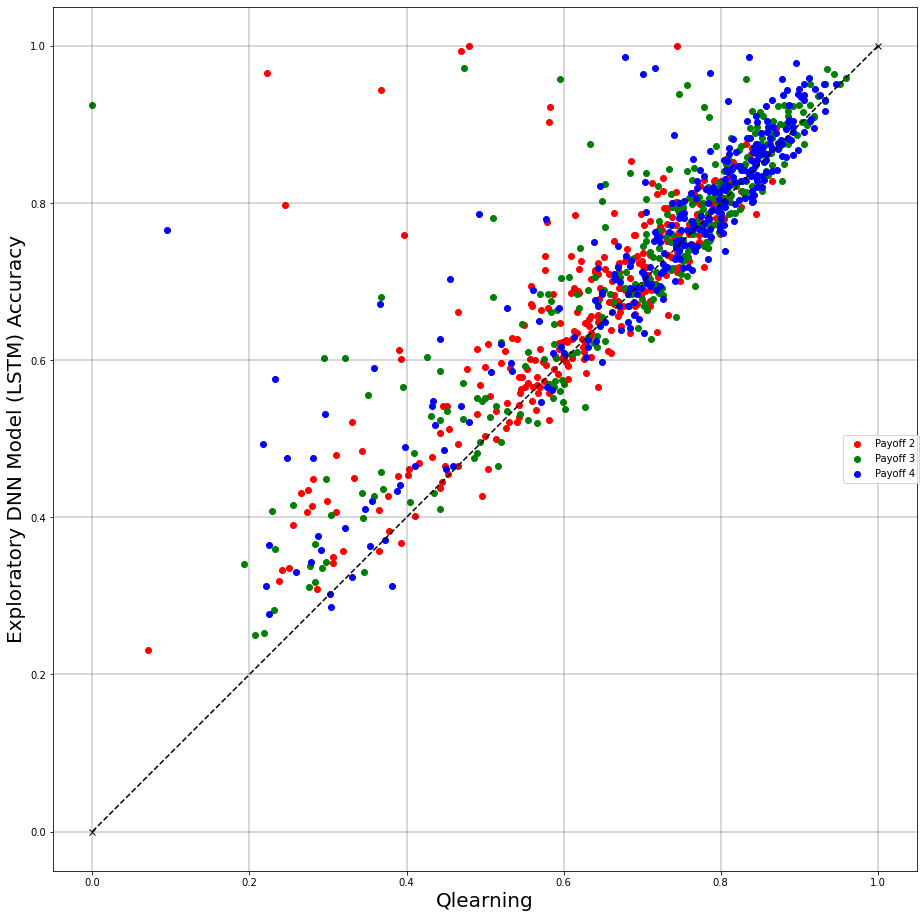

<ipython-input-21-1fb6e0a4b2e1>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(saving_dir,'all_payoffs_participant_accuracy_comparison_scatterplot_LSTM_VS_Qlearning.svg'),quality=95,dpi=200, format='svg')


<Figure size 432x288 with 0 Axes>

In [21]:
%matplotlib inline
# 12.8.20
# new scatter plot - qlearn vs general
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1, 1, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1, 1.0, 1, 1),  # white
    "savefig.facecolor": (1, 1.0, 1.0, 1),  # blue  with alpha = 20%
})

x_range = np.arange(4,150)
fig=plt.figure(figsize=(12,12))
ax=fig.add_axes([0,0,1,1])
ax.scatter(x=qlearning_payoff_2_person_real_accuracies, y=general_payoff2_lstm_accs, color ='r')
ax.scatter(x=qlearning_payoff_3_person_real_accuracies, y=general_payoff3_lstm_accs, color ='g')
ax.scatter(x=qlearning_payoff_4_person_real_accuracies, y=general_payoff4_lstm_accs, color ='b')
fig.legend(['Payoff 2','Payoff 3','Payoff 4'], loc= 'right')

x1, y1 = [0, 1], [0, 1]
plt.plot(x1, y1,'k--', marker = 'x')
ax.set_xlabel('Qlearning', fontdict=my_font_dict)
ax.set_ylabel('Exploratory DNN Model (LSTM) Accuracy', fontdict=my_font_dict)
# ax.set_title('scatter plot')

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='black', linestyle='-', linewidth=0.3)

plt.show()

plt.savefig(os.path.join(saving_dir,'all_payoffs_participant_accuracy_comparison_scatterplot_LSTM_VS_Qlearning.svg'),quality=95,dpi=200, format='svg')

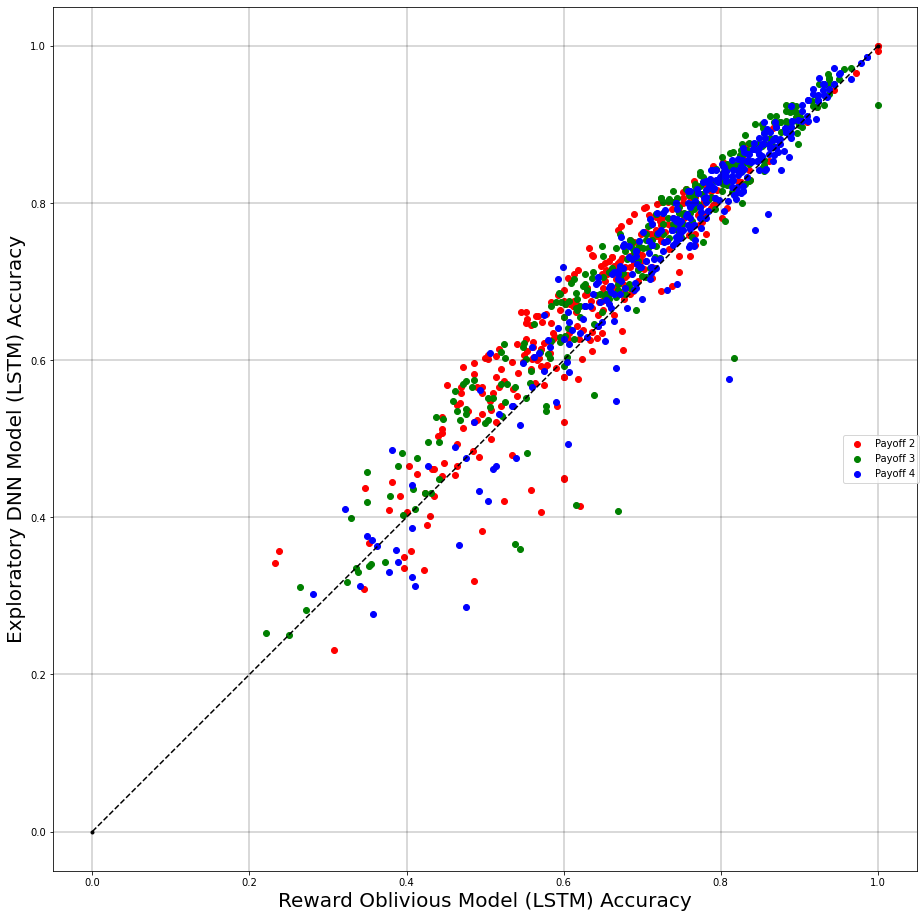

<ipython-input-22-749b3e02851b>:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(saving_dir,'all_payoffs_participant_accuracy_comparison_scatterplot_LSTM_VS_Reward_Oblivious.svg'),quality=95,dpi=200, format='svg')


<Figure size 432x288 with 0 Axes>

In [22]:
# 20.5.21


# %matplotlib inline
# 12.8.20
# new scatter plot - qlearn vs general
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1, 1, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1, 1.0, 1, 1),  # white
    "savefig.facecolor": (1, 1.0, 1.0, 1),  # blue  with alpha = 20%
})

x_range = np.arange(4,150)
fig=plt.figure(figsize=(12,12))
ax=fig.add_axes([0,0,1,1])
ax.scatter(x=no_reward_payoff2_lstm_accs, y=general_payoff2_lstm_accs, color ='r')
ax.scatter(x=no_reward_payoff3_lstm_accs, y=general_payoff3_lstm_accs, color ='g')
ax.scatter(x=no_reward_payoff4_lstm_accs, y=general_payoff4_lstm_accs, color ='b')
fig.legend(['Payoff 2','Payoff 3','Payoff 4'], loc= 'right')

x1, y1 = [0, 1], [0, 1]
plt.plot(x1, y1,'k--', marker = '.')
ax.set_xlabel('Reward Oblivious Model (LSTM) Accuracy', fontdict=my_font_dict)
ax.set_ylabel('Exploratory DNN Model (LSTM) Accuracy', fontdict=my_font_dict)
# ax.set_title('scatter plot')

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='black', linestyle='-', linewidth=0.3)

plt.show()

plt.savefig(os.path.join(saving_dir,'all_payoffs_participant_accuracy_comparison_scatterplot_LSTM_VS_Reward_Oblivious.svg'),quality=95,dpi=200, format='svg')

<ipython-input-23-17effadef813>:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(os.path.join(saving_dir,'Participants accuracies panel.svg'),quality=95,dpi=200, format='svg')


explain/one_stop_shop/updated_qlearning_paper_addition/Participants accuracies panel.svg


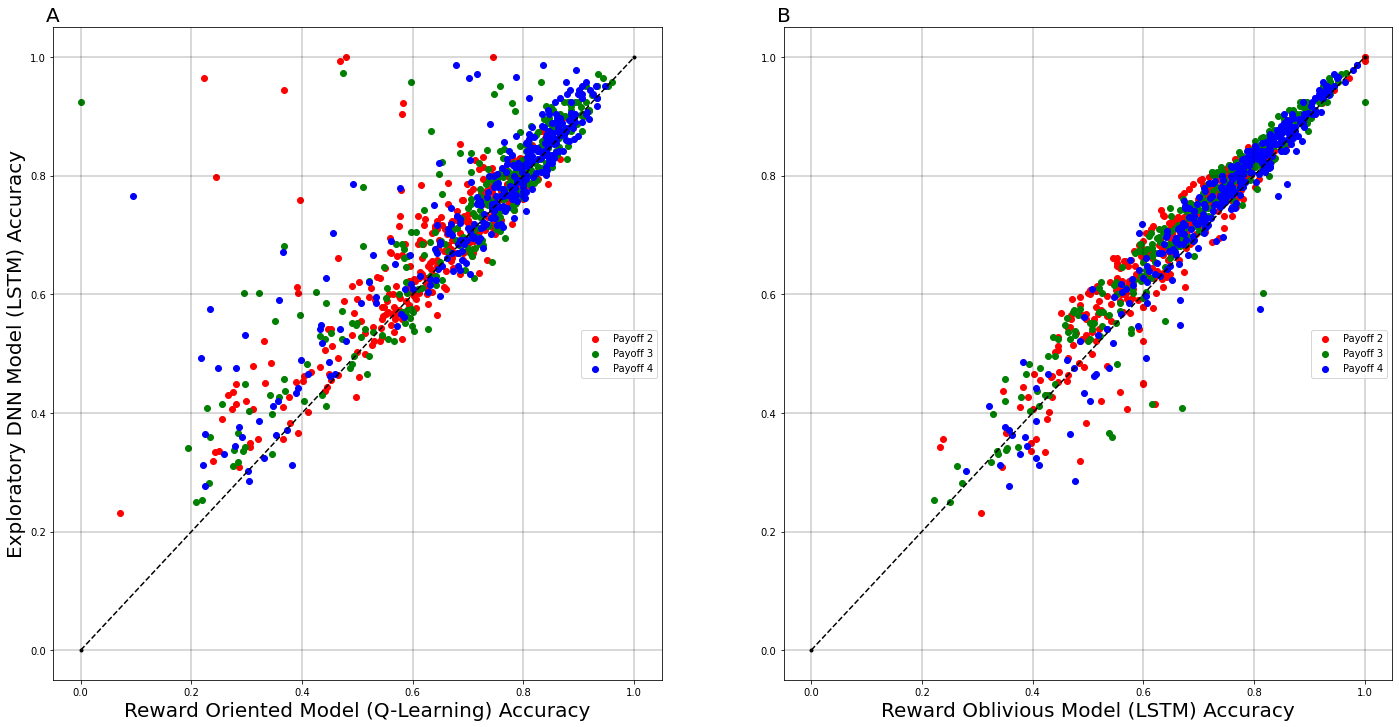

In [23]:
# 20.5.21 show both scatterplots together
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1, 1, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1, 1.0, 1, 1),  # white
    "savefig.facecolor": (1, 1.0, 1.0, 1),  # blue  with alpha = 20%
})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,12),frameon=False)
# fig.suptitle('Models comparison in payoff{}'.format(payoff_num),y=0.99,x=0.5)
# x = np.arange(4,150)

# gen vs qlearning

# axes[0].add_axes([0,0,1,1])
color_axes(axes[0])
# ax=fig.add_axes([0,0,1,1])
axes[0].scatter(x=qlearning_payoff_2_person_real_accuracies, y=general_payoff2_lstm_accs, color ='r')
axes[0].scatter(x=qlearning_payoff_3_person_real_accuracies, y=general_payoff3_lstm_accs, color ='g')
axes[0].scatter(x=qlearning_payoff_4_person_real_accuracies, y=general_payoff4_lstm_accs, color ='b')
axes[0].legend(['Payoff 2','Payoff 3','Payoff 4'], loc= 'right')
x1, y1 = [0, 1], [0, 1]
axes[0].plot(x1, y1,'k--', marker = '.')
axes[0].set_xlabel('Reward Oriented Model (Q-Learning) Accuracy', fontdict=my_font_dict)
axes[0].set_ylabel('Exploratory DNN Model (LSTM) Accuracy', fontdict=my_font_dict)
# axes[1].legend(legend_elements, loc= 'lower right')


# accuracy
x_range = np.arange(4,150)
# axes[1].add_axes([0,0,1,1])
color_axes(axes[1])
# ax=fig.add_axes([0,0,1,1])
axes[1].scatter(x=no_reward_payoff2_lstm_accs, y=general_payoff2_lstm_accs, color ='r')
axes[1].scatter(x=no_reward_payoff3_lstm_accs, y=general_payoff3_lstm_accs, color ='g')
axes[1].scatter(x=no_reward_payoff4_lstm_accs, y=general_payoff4_lstm_accs, color ='b')
axes[1].legend(['Payoff 2','Payoff 3','Payoff 4'], loc= 'right')
x1, y1 = [0, 1], [0, 1]
axes[1].plot(x1, y1,'k--', marker = '.')
axes[1].set_xlabel('Reward Oblivious Model (LSTM) Accuracy', fontdict=my_font_dict)
# axes[1].set_ylabel('Exploratory DNN Model (LSTM) Accuracy', fontdict=my_font_dict)

#     axes[1].legend(list(payoff_accuracy.columns), loc= 'lower right')
# axes[1].legend(legend_elements, loc= 'lower right')



axs = axes.flatten()
axs[0].set_title('A', fontsize=20, x=0)
axs[1].set_title('B', fontsize=20, x=0)


fig.savefig(os.path.join(saving_dir,'Participants accuracies panel.svg'),quality=95,dpi=200, format='svg')
print(os.path.join(saving_dir,'Participants accuracies panel.svg'))

### look at the participant that are better in no-reward

In [70]:
def find_pars_better_in_nr(nr_payoff, gen_payoff, payoff, get_true_par_num = 1):
    if payoff==2:
        offset=0 + get_true_par_num
    if payoff==3: 
        offset=329 +get_true_par_num
    if payoff==4:
        offset=641 +get_true_par_num
    
    res = np.where(np.array(nr_payoff)>np.array(gen_payoff))[0] + offset
    return res

In [71]:
payoff2_better_nr = find_pars_better_in_nr(nr_payoff=no_reward_payoff2_lstm_accs, gen_payoff=general_payoff2_lstm_accs, payoff=2)
payoff3_better_nr = find_pars_better_in_nr(nr_payoff=no_reward_payoff3_lstm_accs, gen_payoff=general_payoff3_lstm_accs, payoff=3)
payoff4_better_nr = find_pars_better_in_nr(nr_payoff=no_reward_payoff4_lstm_accs, gen_payoff=general_payoff4_lstm_accs, payoff=4)

In [199]:
payoff2_better_nr

array([  5,   7,  16,  19,  22,  23,  25,  27,  35,  44,  48,  51,  52,
        57,  64,  81,  85,  90,  95,  98, 103, 111, 121, 133, 146, 158,
       159, 163, 174, 188, 193, 196, 223, 230, 235, 236, 237, 247, 250,
       258, 260, 269, 278, 280, 282, 285, 295, 297, 299, 317, 323, 328],
      dtype=int64)

I want to see how "creative" they are in their choices

In [24]:
def count_stickiness(person_df):
    """
    probability of switch - count how many times the person pressed the same choice again (first doesn't count). person_df is filled NAs with -1s
    """
    sticky_count = 0
    for i,choice in enumerate(person_df.choice):
        if i==0:
            continue
        if (person_df.choice[i] == person_df.choice[i-1]):
            sticky_count+=1
    return sticky_count/i

In [25]:
def count_stickiness_without_nones(person_df):
    """
    probability of switch - count how many times the person pressed the same choice again (first doesn't count). person_df is filled NAs with -1s
    """
    sticky_count = 0
    prev_choice = -1
    cur_choice = -1
    actual_choices = 0
    
    for i,choice in enumerate(person_df.choice):
        if i==0:
            prev_choice = choice
            if prev_choice != -1 :
                actual_choices += 1
            continue
            
        cur_choice = choice
        if cur_choice != -1:
            actual_choices += 1
        else:
            continue
        
        if cur_choice != -1 and prev_choice != -1:
            if (cur_choice == prev_choice):
                sticky_count += 1
            
            prev_choice = cur_choice
           
    #print("actual:",actual_choices)
    rate = sticky_count/actual_choices
#     print("rate:",rate)

    return rate

In [26]:
# see how sticky they are:
def get_stickyness_rate(data, participants, payoff_num, sticky_nones=True):
    st = []
    par_st_dict = {}
    for i, par in enumerate(participants):
        par_df = data[data['user']==par].reset_index(drop=True).copy()
        true_payoff = par_df[par_df['payoff_structure']==payoff_num]['payoff_structure'].iloc[0]
        assert(true_payoff==payoff_num)
        if sticky_nones:
            stickyness = count_stickiness_without_nones(par_df)
            st.append(stickyness)
            
        else:
            stickyness = count_stickiness_without_nones(par_df)
            st.append(stickyness)
            
        par_st_dict[par] = stickyness
        
    return np.mean(st), st, par_st_dict

In [225]:
mean_stickyness_p2, stickyness_p2, par_st_stick_dict_p2 = get_stickyness_rate(data, payoff2_better_nr, payoff_num=2)
mean_stickyness_p2

0.2554264873051451

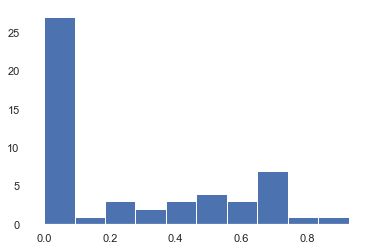

In [231]:
%matplotlib inline
plt.hist(stickyness_p2)
plt.show()

In [226]:
mean_stickyness_p3, stickyness_p3, par_st_stick_dict_p3 = get_stickyness_rate(data, payoff3_better_nr, payoff_num=3)
mean_stickyness_p3

0.20580182423446614

now lets look at the ones with low sticyness rates (lowe than 5)

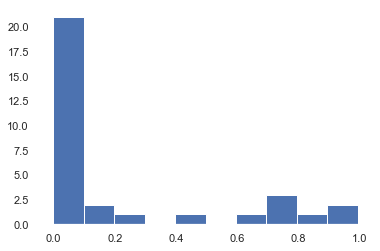

In [233]:
%matplotlib inline
plt.hist(stickyness_p3)
plt.show()

In [227]:
mean_stickyness_p4, stickyness_p4, par_st_stick_dict_p4 = get_stickyness_rate(data, payoff4_better_nr, payoff_num=4)
mean_stickyness_p4

0.32532894097584003

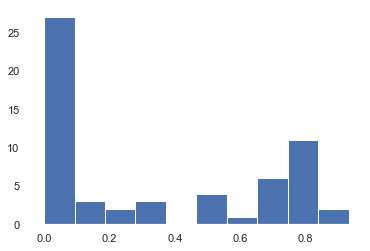

In [234]:
%matplotlib inline
plt.hist(stickyness_p4)
plt.show()

In [235]:
def patterns_find(df, par_number=-1, seq_length = 4, choice=True):
    """
    Gets a sliced df & participant number and returns a Counter object containing all the windowed sequences of seq_length
    choice indicates if I want to use the choice column (True) or the lstm prediction column (False)
    If par_number==-1 this means I want to find patterns across all participants.
    """
    
    if par_number!=-1:
        assert(par_number in list(df.user.unique())),'the particiapnt number is not found in this sliced dataframe'
        cur_data = df[df['user']==par_number].copy().reset_index(drop=True)
    else:
        cur_data = df.copy().reset_index(drop=True)
    indexer = np.arange(seq_length)[None, :]  + np.arange(cur_data.shape[0]-3)[:, None]
    list_of_indices = []

    for i in indexer.flatten():
        if (i+1)==cur_data.shape[0]-1:
            list_of_indices.append(i+1)
            break
        else:
            list_of_indices.append(i+1)
    new_pd = pd.DataFrame(cur_data,index=list_of_indices)
    if choice:
        new_pd_patterned = np.reshape(np.asarray(new_pd.choice),(-1,4))
    else:
        new_pd_patterned = np.reshape(np.asarray(new_pd.prediction),(-1,4))
    patterns = [str(e) for e in new_pd_patterned]
    counter_obj = Counter(str(e) for e in patterns)


    sum_sanity_check = 0    # i want this to be 146 - number of possible patterns
    for ob in counter_obj:
        sum_sanity_check += counter_obj[ob]
    if par_number!=-1:
        assert(sum_sanity_check==146),'sum of possible patterns is not 146 for some reason'

    return counter_obj

In [240]:
from collections import Counter


In [241]:
new_df_sliced_p2 = data[data['user'].isin(payoff2_better_nr)].copy()
new_df_sliced_p3 = data[data['user'].isin(payoff3_better_nr)].copy()
new_df_sliced_p4 = data[data['user'].isin(payoff4_better_nr)].copy()

In [249]:
counter_objects = {}
for par in new_df_sliced_p2.user.unique():
    if par_st_stick_dict_p2[par]<0.3:
        counter_objects[par] = patterns_find(new_df_sliced_p2, par_number=par)

In [250]:
counter_objects

{16: Counter({'[-1.  2.  4.  3.]': 1,
          '[2. 4. 3. 2.]': 9,
          '[4. 3. 2. 1.]': 12,
          '[3. 2. 1. 4.]': 8,
          '[2. 1. 4. 3.]': 6,
          '[1. 4. 3. 2.]': 6,
          '[2. 1. 4. 2.]': 3,
          '[1. 4. 2. 3.]': 3,
          '[4. 2. 3. 1.]': 4,
          '[2. 3. 1. 4.]': 1,
          '[3. 1. 4. 3.]': 1,
          '[1. 4. 3. 1.]': 1,
          '[4. 3. 1. 2.]': 2,
          '[3. 1. 2. 2.]': 1,
          '[1. 2. 2. 1.]': 1,
          '[2. 2. 1. 4.]': 1,
          '[3. 2. 1. 3.]': 2,
          '[2. 1. 3. 2.]': 2,
          '[1. 3. 2. 4.]': 7,
          '[3. 2. 4. 1.]': 5,
          '[2. 4. 1. 3.]': 5,
          '[4. 1. 3. 2.]': 5,
          '[1. 3. 2. 2.]': 1,
          '[3. 2. 2. 1.]': 1,
          '[2. 2. 1. 3.]': 1,
          '[2. 1. 3. 4.]': 2,
          '[1. 3. 4. 4.]': 1,
          '[3. 4. 4. 2.]': 1,
          '[4. 4. 2. 1.]': 1,
          '[4. 2. 1. 3.]': 2,
          '[2. 1. 3. 1.]': 1,
          '[1. 3. 1. 2.]': 1,
          '[3. 1. 2. 4.]': 5,
 

In [251]:
par_st_stick_dict_p2[328]

0.0

In [252]:
count_stickiness_without_nones(data[data['user']==328])

0.0

In [257]:
data[data['user']==328]

,user,choice,reward,time,payoff_structure,reward_1,reward_2,reward_3,reward_4
49050,328,-1.0,-1.0,-1.0,2,84,87,42,23
49051,328,3.0,46.0,1194.0,2,90,90,46,18
49052,328,3.0,53.0,902.0,2,80,84,53,28
49053,328,3.0,50.0,877.0,2,87,81,50,24
49054,328,4.0,28.0,1097.0,2,86,92,61,28
49055,328,3.0,55.0,1255.0,2,75,78,55,30
49056,328,1.0,71.0,897.0,2,71,78,50,34
49057,328,1.0,75.0,750.0,2,75,83,58,43
49058,328,1.0,77.0,715.0,2,77,80,52,30
49059,328,1.0,70.0,646.0,2,70,80,43,28


In [27]:
saving_dir

'explain/one_stop_shop/new_scatterplot/'

In [73]:
(np.sum(payoff_2_person_real_accuracies) + np.sum(payoff_3_person_real_accuracies) + np.sum(payoff_4_person_real_accuracies)) / (len(payoff_2_person_real_accuracies) + len(payoff_3_person_real_accuracies) + len(payoff_4_person_real_accuracies))

0.6880359333423275

In [27]:
q_leanr_avg = np.mean([*qlearning_payoff_2_person_real_accuracies, *qlearning_payoff_3_person_real_accuracies, *qlearning_payoff_4_person_real_accuracies])

pd.DataFrame({'payoff2':[np.mean(qlearning_payoff_2_person_real_accuracies)],
              'payoff3':[np.mean(qlearning_payoff_3_person_real_accuracies)],
              'payoff4':[np.mean(qlearning_payoff_4_person_real_accuracies)],
              'full_avg':q_leanr_avg
             },
             index=['q_learn_model'])

,payoff2,payoff3,payoff4,full_avg
q_learn_model,0.625263,0.698345,0.725556,0.682565


# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# Panels

In [27]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1, 1, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1, 1.0, 1, 1),  # white
    "savefig.facecolor": (1, 1.0, 1.0, 1),  # blue  with alpha = 20%
})

In [28]:
def color_axes(axes_):
    axes_.spines['bottom'].set_color('black')
    axes_.spines['top'].set_color('black') 
    axes_.spines['right'].set_color('black')
    axes_.spines['left'].set_color('black')
    axes_.grid(color='black', linestyle='-', linewidth=0.3)

In [29]:
with open('explain/prediction_dist_plots/updated_qlearning_paper_addition/payoff2_true_false_agr_dist_list.pkl', 'rb') as f:
    payoff2_true_false_agr_dist_list = pickle.load(f)
#     payoff2_true_false_dist_list = [gen_nr_dist, gen_ql_dist, ql_nr_dist]

with open('explain/prediction_dist_plots/updated_qlearning_paper_addition/payoff3_true_false_agr_dist_list.pkl', 'rb') as f:
    payoff3_true_false_agr_dist_list = pickle.load(f)
    
with open('explain/prediction_dist_plots/updated_qlearning_paper_addition/payoff4_true_false_agr_dist_list.pkl', 'rb') as f:
    payoff4_true_false_agr_dist_list = pickle.load(f)

In [30]:
new_cols = {"reward_1":"Reward 1", "reward_2":"Reward 2", "reward_3":"Reward 3", "reward_4":"Reward 4"}
data = pd.read_csv('DataAllSubjectsRewards.csv')

pos_2 = data[(data['payoff_structure']==2) & (data['user']==1)].copy().reset_index(drop=True)
pos_2.drop(columns=['user','choice','reward','time','payoff_structure'],inplace=True)
pos_2.rename(columns=new_cols, inplace=True)

pos_3 = data[(data['payoff_structure']==3) & (data['user']==400)].copy().reset_index(drop=True)
pos_3.drop(columns=['user','choice','reward','time','payoff_structure'],inplace=True)
pos_3.rename(columns=new_cols, inplace=True)

pos_4 = data[(data['payoff_structure']==4) & (data['user']==965)].copy().reset_index(drop=True)
pos_4.drop(columns=['user','choice','reward','time','payoff_structure'],inplace=True)
pos_4.rename(columns=new_cols, inplace=True)

In [31]:
payoff2_agreement_df = pd.DataFrame(np.asmatrix(payoff2_true_false_agr_dist_list).T, columns=['General VS Reward-Oblivious', 'General VS Reward-Oriented', 'Reward-Oriented VS Reward-Oblivious'])[4:]
payoff3_agreement_df = pd.DataFrame(np.asmatrix(payoff3_true_false_agr_dist_list).T, columns=['General VS Reward-Oblivious', 'General VS Reward-Oriented', 'Reward-Oriented VS Reward-Oblivious'])[4:]
payoff4_agreement_df = pd.DataFrame(np.asmatrix(payoff4_true_false_agr_dist_list).T, columns=['General VS Reward-Oblivious', 'General VS Reward-Oriented', 'Reward-Oriented VS Reward-Oblivious'])[4:]

In [32]:
def get_avg_acc_per_time_with_stats(payoff_person_true_false_predictions_matrix):
    """
    gets a payoff_person_true_false_predictions_matrix -  which can be either qlearning or lstm 
    return a vector of 150, each entrance is the avg accuracy across all participants in that payoff
    """
    payoff_all_pars_avg_acc_per_time = []
    collection_of_preds = []
    for t in range(payoff_person_true_false_predictions_matrix.shape[1]):
        collect_not_minuses = []
        for pred in payoff_person_true_false_predictions_matrix[:,t]:
            if pred<0:
                continue
            else:
                collect_not_minuses.append(pred[0,0])
        payoff_all_pars_avg_acc_per_time.append(np.mean(collect_not_minuses))

        collection_of_preds.append(collect_not_minuses)
    
#     # fill the first 4 times for collection
#     fill = len(collect_not_minuses)
#     collection_of_preds[0] = [-1]*fill
#     collection_of_preds[1] = [-1]*fill
#     collection_of_preds[2] = [-1]*fill
#     collection_of_preds[3] = [-1]*fill
    
    return payoff_all_pars_avg_acc_per_time, collection_of_preds

In [33]:
general_avg_acc_payoff2 , general_predictions_payoff2 = get_avg_acc_per_time_with_stats(general_payoff2_persons_true_false_predictions_lstm)
general_avg_acc_payoff3 , general_predictions_payoff3 = get_avg_acc_per_time_with_stats(general_payoff3_persons_true_false_predictions_lstm)
general_avg_acc_payoff4 , general_predictions_payoff4 = get_avg_acc_per_time_with_stats(general_payoff4_persons_true_false_predictions_lstm)

no_reward_avg_acc_payoff2 , no_reward_predictions_payoff2 = get_avg_acc_per_time_with_stats(no_reward_payoff2_persons_true_false_predictions_lstm)
no_reward_avg_acc_payoff3 , no_reward_predictions_payoff3 = get_avg_acc_per_time_with_stats(no_reward_payoff3_persons_true_false_predictions_lstm)
no_reward_avg_acc_payoff4 , no_reward_predictions_payoff4 = get_avg_acc_per_time_with_stats(no_reward_payoff4_persons_true_false_predictions_lstm)

reward_oriented_avg_acc_payoff2, reward_oriented_predictions_payoff2= get_avg_acc_per_time_with_stats(payoff_2_person_true_false_predictions_matrix_qlearning)
reward_oriented_avg_acc_payoff3, reward_oriented_predictions_payoff3 = get_avg_acc_per_time_with_stats(payoff_3_person_true_false_predictions_matrix_qlearning)
reward_oriented_avg_acc_payoff4, reward_oriented_predictions_payoff4 = get_avg_acc_per_time_with_stats(payoff_4_person_true_false_predictions_matrix_qlearning)

payoff2_accs_df = pd.DataFrame({"General":general_avg_acc_payoff2, "Reward-Oblivious":no_reward_avg_acc_payoff2, "Reward-Oriented":reward_oriented_avg_acc_payoff2})
payoff3_accs_df = pd.DataFrame({"General":general_avg_acc_payoff3, "Reward-Oblivious":no_reward_avg_acc_payoff3, "Reward-Oriented":reward_oriented_avg_acc_payoff3})
payoff4_accs_df = pd.DataFrame({"General":general_avg_acc_payoff4, "Reward-Oblivious":no_reward_avg_acc_payoff4, "Reward-Oriented":reward_oriented_avg_acc_payoff4})

payoff2_accs_df['Reward-Oriented'][0] = None
payoff2_accs_df['Reward-Oriented'][1] = None
payoff2_accs_df['Reward-Oriented'][2] = None
payoff2_accs_df['Reward-Oriented'][3] = None

/Users/matanfintz/opt/anaconda3/envs/ident/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matanfintz/opt/anaconda3/envs/ident/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
def get_contingency_tables(model1_predictions, model2_predictions):
    """
    gets 2 predictions matrices (lists of lists actually since its not squared) and returns a cont. table for each time t.
    Make sure that there's no -1's
                        Classifier2 Correct, Classifier2 Incorrect
    Classifier1 Correct  4                          2
    Classifier1 Incorrect 1                        3
    """
    assert(len(model1_predictions)==len(model2_predictions))
    cont_tables = []
    for t in range(len(model1_predictions)):
        model1_correct_model2_correct = 0
        model1_wrong_model2_correct = 0
        model1_correct_model2_wrong = 0 
        model1_wrong_model2_wrong = 0
        for pred1, pred2 in zip(model1_predictions[t], model2_predictions[t]):
            if pred1==1 and pred2==1:
                model1_correct_model2_correct = model1_correct_model2_correct + 1
            if pred1==0 and pred2 == 1:
                model1_wrong_model2_correct = model1_wrong_model2_correct + 1
            if pred1 == 1 and pred2 == 0:
                model1_correct_model2_wrong = model1_correct_model2_wrong + 1
            if pred1 == 0 and pred2 == 0:
                model1_wrong_model2_wrong = model1_wrong_model2_wrong + 1
        
        t_table = [[model1_correct_model2_correct, model1_correct_model2_wrong],
                    [model1_wrong_model2_correct, model1_wrong_model2_wrong]]
        cont_tables.append(t_table)
    
    return cont_tables

In [35]:
payoff2_gen_vs_rob_tables = get_contingency_tables(general_predictions_payoff2, no_reward_predictions_payoff2)
payoff3_gen_vs_rob_tables = get_contingency_tables(general_predictions_payoff3, no_reward_predictions_payoff3)
payoff4_gen_vs_rob_tables = get_contingency_tables(general_predictions_payoff4, no_reward_predictions_payoff4)

payoff2_gen_vs_ro_tables = get_contingency_tables(general_predictions_payoff2, reward_oriented_predictions_payoff2)
payoff3_gen_vs_ro_tables = get_contingency_tables(general_predictions_payoff4, reward_oriented_predictions_payoff3)
payoff4_gen_vs_ro_tables = get_contingency_tables(general_predictions_payoff4, reward_oriented_predictions_payoff4)

payoff2_rob_vs_ro_tables = get_contingency_tables(no_reward_predictions_payoff2, reward_oriented_predictions_payoff2)
payoff3_rob_vs_ro_tables = get_contingency_tables(no_reward_predictions_payoff3, reward_oriented_predictions_payoff3)
payoff4_rob_vs_ro_tables = get_contingency_tables(no_reward_predictions_payoff4, reward_oriented_predictions_payoff4)

In [36]:
payoff2_accs_mcnemar = payoff2_accs_df.copy()
payoff3_accs_mcnemar = payoff3_accs_df.copy()
payoff4_accs_mcnemar = payoff4_accs_df.copy()

In [37]:
def creat_pvalues_df(payoff_accs_df, tables, col_name=''):
    for i, row in payoff_accs_df.iterrows():
        val = contingency_tables.mcnemar(tables[i]).pvalue
        payoff_accs_df.at[i, col_name] = val
    
    return payoff_accs_df

In [38]:
def creat_mcvalues_df(payoff_accs_df, tables, col_name=''):
    for i, row in payoff_accs_df.iterrows(): 
        # update 1.1.21
        mc_val = contingency_tables.mcnemar(tables[i]).statistic
        payoff_accs_df.at[i, col_name] = mc_val
        
    return payoff_accs_df

In [39]:
payoff2_accs_mcnemar = creat_pvalues_df(payoff2_accs_mcnemar, payoff2_gen_vs_rob_tables, col_name='pval_general_reward-oblivious')
payoff3_accs_mcnemar = creat_pvalues_df(payoff3_accs_mcnemar, payoff3_gen_vs_rob_tables, col_name='pval_general_reward-oblivious')
payoff4_accs_mcnemar = creat_pvalues_df(payoff4_accs_mcnemar, payoff4_gen_vs_rob_tables, col_name='pval_general_reward-oblivious')

payoff2_accs_mcnemar = creat_pvalues_df(payoff2_accs_mcnemar, payoff2_gen_vs_ro_tables, col_name='pval_general_reward-oriented')
payoff3_accs_mcnemar = creat_pvalues_df(payoff3_accs_mcnemar, payoff3_gen_vs_ro_tables, col_name='pval_general_reward-oriented')
payoff4_accs_mcnemar = creat_pvalues_df(payoff4_accs_mcnemar, payoff4_gen_vs_ro_tables, col_name='pval_general_reward-oriented')

payoff2_accs_mcnemar = creat_pvalues_df(payoff2_accs_mcnemar, payoff2_rob_vs_ro_tables, col_name='pval_reward-oblivious_reward-oriented')
payoff3_accs_mcnemar = creat_pvalues_df(payoff3_accs_mcnemar, payoff3_rob_vs_ro_tables, col_name='pval_reward-oblivious_reward-oriented')
payoff4_accs_mcnemar = creat_pvalues_df(payoff4_accs_mcnemar, payoff4_rob_vs_ro_tables, col_name='pval_reward-oblivious_reward-oriented')

######

payoff2_accs_mcnemar_stat = creat_mcvalues_df(payoff2_accs_mcnemar, payoff2_gen_vs_rob_tables, col_name='mcnmr_general_reward-oblivious')
payoff3_accs_mcnemar_stat = creat_mcvalues_df(payoff3_accs_mcnemar, payoff3_gen_vs_rob_tables, col_name='mcnmr_general_reward-oblivious')
payoff4_accs_mcnemar_stat = creat_mcvalues_df(payoff4_accs_mcnemar, payoff4_gen_vs_rob_tables, col_name='mcnmr_general_reward-oblivious')

payoff2_accs_mcnemar_stat = creat_mcvalues_df(payoff2_accs_mcnemar, payoff2_gen_vs_ro_tables, col_name='mcnmr_general_reward-oriented')
payoff3_accs_mcnemar_stat = creat_mcvalues_df(payoff3_accs_mcnemar, payoff3_gen_vs_ro_tables, col_name='mcnmr_general_reward-oriented')
payoff4_accs_mcnemar_stat = creat_mcvalues_df(payoff4_accs_mcnemar, payoff4_gen_vs_ro_tables, col_name='mcnmr_general_reward-oriented')

payoff2_accs_mcnemar_stat = creat_mcvalues_df(payoff2_accs_mcnemar, payoff2_rob_vs_ro_tables, col_name='mcnmr_reward-oblivious_reward-oriented')
payoff3_accs_mcnemar_stat = creat_mcvalues_df(payoff3_accs_mcnemar, payoff3_rob_vs_ro_tables, col_name='mcnmr_reward-oblivious_reward-oriented')
payoff4_accs_mcnemar_stat = creat_mcvalues_df(payoff4_accs_mcnemar, payoff4_rob_vs_ro_tables, col_name='mcnmr_reward-oblivious_reward-oriented')

In [40]:
saving_dir

'explain/one_stop_shop/updated_qlearning_paper_addition/'

In [41]:
payoff2_accs_mcnemar_stat.to_csv(os.path.join(saving_dir, 'payoff2_mcnemar.csv'), index=False)
payoff3_accs_mcnemar_stat.to_csv(os.path.join(saving_dir, 'payoff3_mcnemar.csv'), index=False)
payoff4_accs_mcnemar_stat.to_csv(os.path.join(saving_dir, 'payoff4_mcnemar.csv'), index=False)

In [42]:
def get_list_of_times_pval(mcnemar_values_df, col_name):
    """
    returns a list of times where pval<0.05
    """
    return np.where(mcnemar_values_df[col_name] < 0.05)[0].tolist()

In [43]:
payoff2_pvals_gen_rob = get_list_of_times_pval(payoff2_accs_mcnemar, col_name='pval_general_reward-oblivious')
payoff3_pvals_gen_rob = get_list_of_times_pval(payoff3_accs_mcnemar, col_name='pval_general_reward-oblivious')
payoff4_pvals_gen_rob = get_list_of_times_pval(payoff4_accs_mcnemar, col_name='pval_general_reward-oblivious')

payoff2_pvals_gen_ro = get_list_of_times_pval(payoff2_accs_mcnemar, col_name='pval_general_reward-oriented')
payoff3_pvals_gen_ro = get_list_of_times_pval(payoff3_accs_mcnemar, col_name='pval_general_reward-oriented')
payoff4_pvals_gen_ro = get_list_of_times_pval(payoff4_accs_mcnemar, col_name='pval_general_reward-oriented')

payoff2_pvals_rob_ro = get_list_of_times_pval(payoff2_accs_mcnemar, col_name='pval_reward-oblivious_reward-oriented')
payoff3_pvals_rob_ro = get_list_of_times_pval(payoff3_accs_mcnemar, col_name='pval_reward-oblivious_reward-oriented')
payoff4_pvals_rob_ro = get_list_of_times_pval(payoff4_accs_mcnemar, col_name='pval_reward-oblivious_reward-oriented')

In [44]:
def create_panel_for_payoff_with_pval(payoff_num, payoff_structure, payoff_accuracy, payoff_agreement_df, pvals1, pvals2, pvals3):
    fig, axes = plt.subplots(nrows=3,figsize=(15,13), sharex=True,frameon=False)
    fig.suptitle('Models comparison in payoff{}'.format(payoff_num),y=0.99,x=0.5)
    x = np.arange(4,150)

    # payoff structure

    # plt.subplot(3, 1, 1)
    p0 = axes[0].plot(payoff_structure, label=list(payoff_structure.columns))
    color_axes(axes[0])
    axes[0].legend(list(payoff_structure.columns), loc= 'lower right')
    axes[0].set_ylabel('Reward')



    # accuracy
    p1 = axes[1].plot(payoff_accuracy, label=list(payoff_accuracy.columns))
    p1_pvals = axes[1].scatter(pvals1, [1]*len(pvals1), label='General vs Reward-Oblivious')
    p2_pvals = axes[1].scatter(pvals2, [1.05]*len(pvals2),label='General vs Reward-Oriented')
    p3_pvals = axes[1].scatter(pvals3, [1.1]*len(pvals3), label='Reward-Oriented vs Reward-Oblivious')
    color_axes(axes[1])
    axes[1].set_ylabel('Accuracy')
    p1[0].set_color('blue')
    p1[0].set_label('General')
    p1[1].set_color('green')
    p1[1].set_label('Reward-Oblivious')
    p1[2].set_color('red')
    p1[2].set_label('Reward-Oriented')
    
    legend_elements = [
        p1[0].get_label(),
        p1[1].get_label(),
        p1[2].get_label(),
        p1_pvals.get_label(),
        p2_pvals.get_label(),
        p3_pvals.get_label()
    ]
    
#     axes[1].legend(list(payoff_accuracy.columns), loc= 'lower right')
    axes[1].legend(legend_elements, loc= 'lower right')
  
    

    # all models' agreement
    p2 = axes[2].plot(payoff_agreement_df) 
    color_axes(axes[2])
    axes[2].set_ylabel('Similarity')
    p2[0].set_color('cyan')
    p2[1].set_color('magenta')
    p2[2].set_color('black')
    axes[2].legend(list(payoff_agreement_df.columns), loc= 'lower right')

    axs = axes.flatten()
    axs[0].set_title('A', fontsize=20, x=0)
    axs[1].set_title('B', fontsize=20, x=0)
    axs[2].set_title('C', fontsize=20, x=0)


    plt.xlabel("Time")
    fig.savefig(os.path.join(saving_dir,'Comparison panel payoff{} with pvals.svg'.format(payoff_num)),quality=95,dpi=200, format='svg')
    print(os.path.join(saving_dir,'Comparison panel payoff{} with pvals.svg'.format(payoff_num)))

<ipython-input-44-aaae866fa815>:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(os.path.join(saving_dir,'Comparison panel payoff{} with pvals.svg'.format(payoff_num)),quality=95,dpi=200, format='svg')


explain/one_stop_shop/updated_qlearning_paper_addition/Comparison panel payoff2 with pvals.svg


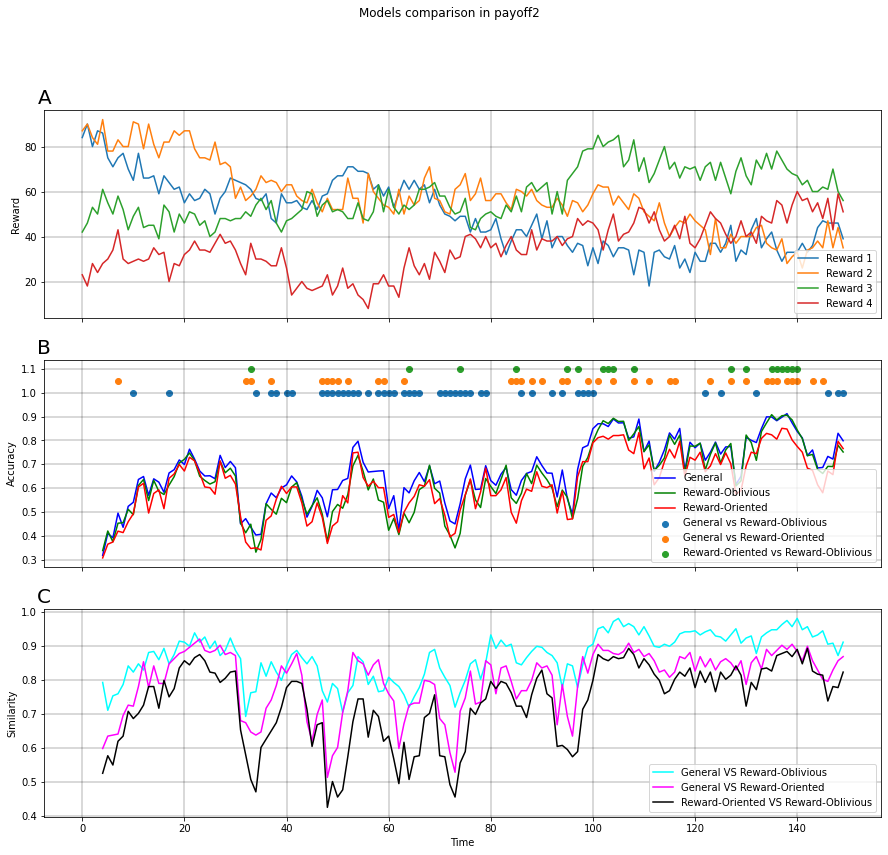

In [45]:
create_panel_for_payoff_with_pval(payoff_num=2, payoff_structure=pos_2, payoff_accuracy=payoff2_accs_df, payoff_agreement_df=payoff2_agreement_df, pvals1=payoff2_pvals_gen_rob, pvals2=payoff2_pvals_gen_ro, pvals3=payoff2_pvals_rob_ro)

<ipython-input-44-aaae866fa815>:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(os.path.join(saving_dir,'Comparison panel payoff{} with pvals.svg'.format(payoff_num)),quality=95,dpi=200, format='svg')


explain/one_stop_shop/updated_qlearning_paper_addition/Comparison panel payoff3 with pvals.svg


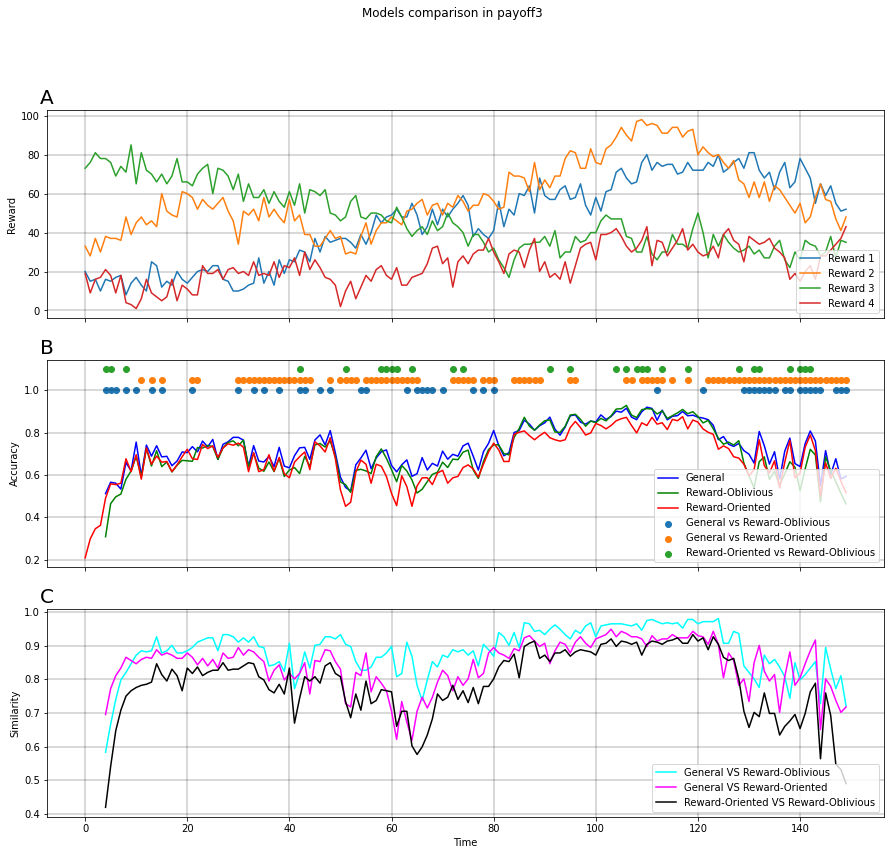

In [46]:
create_panel_for_payoff_with_pval(payoff_num=3, payoff_structure=pos_3, payoff_accuracy=payoff3_accs_df, payoff_agreement_df=payoff3_agreement_df, pvals1=payoff3_pvals_gen_rob, pvals2=payoff3_pvals_gen_ro, pvals3=payoff3_pvals_rob_ro)

<ipython-input-44-aaae866fa815>:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(os.path.join(saving_dir,'Comparison panel payoff{} with pvals.svg'.format(payoff_num)),quality=95,dpi=200, format='svg')


explain/one_stop_shop/updated_qlearning_paper_addition/Comparison panel payoff4 with pvals.svg


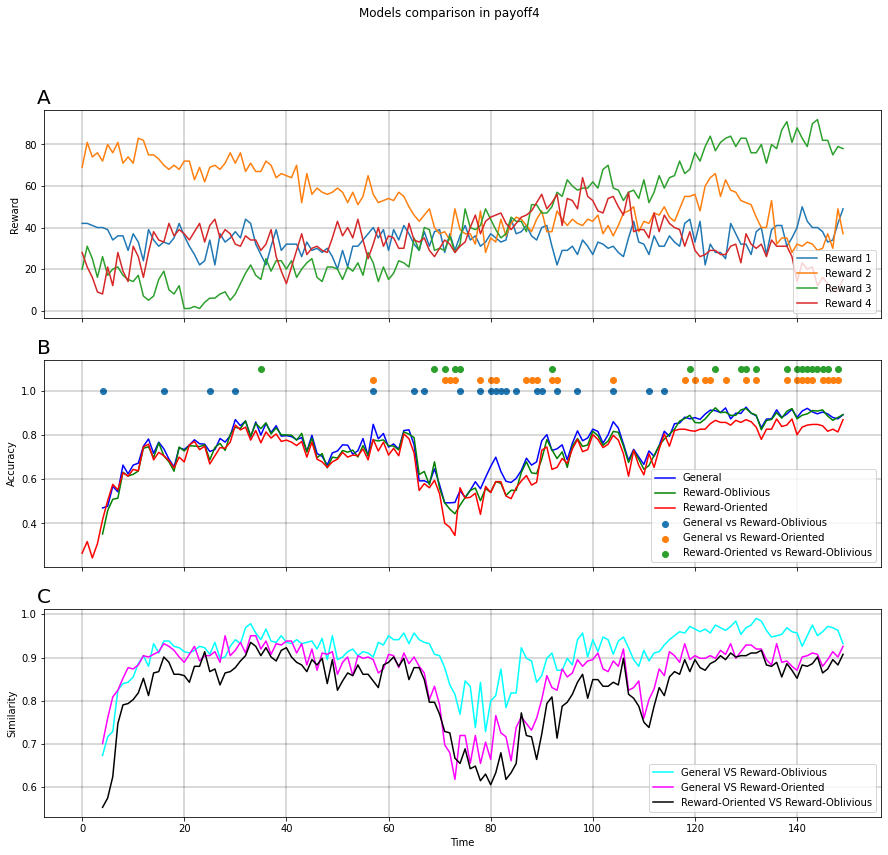

In [47]:
create_panel_for_payoff_with_pval(payoff_num=4, payoff_structure=pos_4, payoff_accuracy=payoff4_accs_df, payoff_agreement_df=payoff4_agreement_df, pvals1=payoff4_pvals_gen_rob, pvals2=payoff4_pvals_gen_ro, pvals3=payoff4_pvals_rob_ro)

# Accuracy over sequence lengths

In [102]:
# Train results for seq=2 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/2\\fold0/----average train accuracy:0.69743776---- highest train accuracy:0.70319057',
#  'saved_model/corss_val/general_model/hp_seq_len/2\\fold1/----average train accuracy:0.6968444---- highest train accuracy:0.7018483',
#  'saved_model/corss_val/general_model/hp_seq_len/2\\fold2/----average train accuracy:0.69579965---- highest train accuracy:0.7007949',
#  'saved_model/corss_val/general_model/hp_seq_len/2\\fold3/----average train accuracy:0.69462276---- highest train accuracy:0.69909346',
#  'saved_model/corss_val/general_model/hp_seq_len/2\\fold4/----average train accuracy:0.7064296---- highest train accuracy:0.7098457']


test_seq_2=['saved_model/corss_val/general_model/hp_seq_len/2\\fold0/----average test accuracy:0.70266396---- highest test accuracy:0.7265625',
 'saved_model/corss_val/general_model/hp_seq_len/2\\fold1/----average test accuracy:0.70789534---- highest test accuracy:0.7246094',
 'saved_model/corss_val/general_model/hp_seq_len/2\\fold2/----average test accuracy:0.70961267---- highest test accuracy:0.71875',
 'saved_model/corss_val/general_model/hp_seq_len/2\\fold3/----average test accuracy:0.7126808---- highest test accuracy:0.7265625',
 'saved_model/corss_val/general_model/hp_seq_len/2\\fold4/----average test accuracy:0.6702833---- highest test accuracy:0.72527474']

# Train results for seq=3 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/3\\fold0/----average train accuracy:0.7186975---- highest train accuracy:0.7270199',
#  'saved_model/corss_val/general_model/hp_seq_len/3\\fold1/----average train accuracy:0.71829903---- highest train accuracy:0.7276714',
#  'saved_model/corss_val/general_model/hp_seq_len/3\\fold2/----average train accuracy:0.7188148---- highest train accuracy:0.726138',
#  'saved_model/corss_val/general_model/hp_seq_len/3\\fold3/----average train accuracy:0.71595603---- highest train accuracy:0.72585255',
#  'saved_model/corss_val/general_model/hp_seq_len/3\\fold4/----average train accuracy:0.72719127---- highest train accuracy:0.7359394']


test_seq_3=['saved_model/corss_val/general_model/hp_seq_len/3\\fold0/----average test accuracy:0.7215673---- highest test accuracy:0.7319336',
 'saved_model/corss_val/general_model/hp_seq_len/3\\fold1/----average test accuracy:0.72080886---- highest test accuracy:0.7441406',
 'saved_model/corss_val/general_model/hp_seq_len/3\\fold2/----average test accuracy:0.72347707---- highest test accuracy:0.73828125',
 'saved_model/corss_val/general_model/hp_seq_len/3\\fold3/----average test accuracy:0.72951066---- highest test accuracy:0.7524414',
 'saved_model/corss_val/general_model/hp_seq_len/3\\fold4/----average test accuracy:0.685962---- highest test accuracy:0.7026367']


# Train results for seq=4 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/4\\fold0/----average train accuracy:0.7343996---- highest train accuracy:0.7466801',
#  'saved_model/corss_val/general_model/hp_seq_len/4\\fold1/----average train accuracy:0.73457426---- highest train accuracy:0.74807006',
#  'saved_model/corss_val/general_model/hp_seq_len/4\\fold2/----average train accuracy:0.7334012---- highest train accuracy:0.7467825',
#  'saved_model/corss_val/general_model/hp_seq_len/4\\fold3/----average train accuracy:0.73097575---- highest train accuracy:0.7449482',
#  'saved_model/corss_val/general_model/hp_seq_len/4\\fold4/----average train accuracy:0.74191767---- highest train accuracy:0.7547348']


# test_seq_4=['saved_model/corss_val/general_model/hp_seq_len/4\\fold0/----average test accuracy:0.7284037---- highest test accuracy:0.7495117',
#  'saved_model/corss_val/general_model/hp_seq_len/4\\fold1/----average test accuracy:0.7292933---- highest test accuracy:0.7504883',
#  'saved_model/corss_val/general_model/hp_seq_len/4\\fold2/----average test accuracy:0.72721666---- highest test accuracy:0.7529297',
#  'saved_model/corss_val/general_model/hp_seq_len/4\\fold3/----average test accuracy:0.7387695---- highest test accuracy:0.7602539',
#  'saved_model/corss_val/general_model/hp_seq_len/4\\fold4/----average test accuracy:0.69093317---- highest test accuracy:0.70751953']

# older CV model for seq=4
test_seq_4=['saved_model/corss_val/general_model/fold0/----average test accuracy:0.72938126---- highest test accuracy:0.7518657',
 'saved_model/corss_val/general_model/fold1/----average test accuracy:0.72858906---- highest test accuracy:0.75',
 'saved_model/corss_val/general_model/fold2/----average test accuracy:0.72914827---- highest test accuracy:0.75439453',
 'saved_model/corss_val/general_model/fold3/----average test accuracy:0.7381668---- highest test accuracy:0.74560547',
 'saved_model/corss_val/general_model/fold4/----average test accuracy:0.6931991---- highest test accuracy:0.7073892']

# Train results for seq=5 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/5\\fold0/----average train accuracy:0.74116105---- highest train accuracy:0.7572236',
#  'saved_model/corss_val/general_model/hp_seq_len/5\\fold1/----average train accuracy:0.7419613---- highest train accuracy:0.7601643', 
#  'saved_model/corss_val/general_model/hp_seq_len/5\\fold2/----average train accuracy:0.7409074---- highest train accuracy:0.75949925',
#  'saved_model/corss_val/general_model/hp_seq_len/5\\fold3/----average train accuracy:0.73863983---- highest train accuracy:0.75660086',
#  'saved_model/corss_val/general_model/hp_seq_len/5\\fold4/----average train accuracy:0.7514091---- highest train accuracy:0.76927805']


test_seq_5=['saved_model/corss_val/general_model/hp_seq_len/5\\fold0/----average test accuracy:0.73164874---- highest test accuracy:0.75341797',
 'saved_model/corss_val/general_model/hp_seq_len/5\\fold1/----average test accuracy:0.7266043---- highest test accuracy:0.73779297',
 'saved_model/corss_val/general_model/hp_seq_len/5\\fold2/----average test accuracy:0.7294124---- highest test accuracy:0.7475586', 
 'saved_model/corss_val/general_model/hp_seq_len/5\\fold3/----average test accuracy:0.73751885---- highest test accuracy:0.7519531',
 'saved_model/corss_val/general_model/hp_seq_len/5\\fold4/----average test accuracy:0.69434---- highest test accuracy:0.7138672']


# Train results for seq=6 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/6\\fold0/----average train accuracy:0.75037974---- highest train accuracy:0.76979005',
#  'saved_model/corss_val/general_model/hp_seq_len/6\\fold1/----average train accuracy:0.75209045---- highest train accuracy:0.7719154', 'saved_model/corss_val/general_model/hp_seq_len/6\\fold2/----average train accuracy:0.7478511---- highest train accuracy:0.7678787', 'saved_model/corss_val/general_model/hp_seq_len/6\\fold3/----average train accuracy:0.74656516---- highest train accuracy:0.76814365', 'saved_model/corss_val/general_model/hp_seq_len/6\\fold4/----average train accuracy:0.757038---- highest train accuracy:0.77707523']


test_seq_6 = ['saved_model/corss_val/general_model/hp_seq_len/6\\fold0/----average test accuracy:0.7317986---- highest test accuracy:0.7470703',
 'saved_model/corss_val/general_model/hp_seq_len/6\\fold1/----average test accuracy:0.728501---- highest test accuracy:0.7504883',
 'saved_model/corss_val/general_model/hp_seq_len/6\\fold2/----average test accuracy:0.7357544---- highest test accuracy:0.7741935',
 'saved_model/corss_val/general_model/hp_seq_len/6\\fold3/----average test accuracy:0.7461369---- highest test accuracy:0.75634766',
 'saved_model/corss_val/general_model/hp_seq_len/6\\fold4/----average test accuracy:0.69994736---- highest test accuracy:0.72021484']


# Train results for seq=7 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/7\\fold0/----average train accuracy:0.7522943---- highest train accuracy:0.7737942',
#  'saved_model/corss_val/general_model/hp_seq_len/7\\fold1/----average train accuracy:0.75565237---- highest train accuracy:0.7769185', 
#  'saved_model/corss_val/general_model/hp_seq_len/7\\fold2/----average train accuracy:0.75333977---- highest train accuracy:0.7765465',
#  'saved_model/corss_val/general_model/hp_seq_len/7\\fold3/----average train accuracy:0.75095135---- highest train accuracy:0.7730789',
#  'saved_model/corss_val/general_model/hp_seq_len/7\\fold4/----average train accuracy:0.7621781---- highest train accuracy:0.783765']


test_seq_7 =['saved_model/corss_val/general_model/hp_seq_len/7\\fold0/----average test accuracy:0.7358662---- highest test accuracy:0.74902344',
 'saved_model/corss_val/general_model/hp_seq_len/7\\fold1/----average test accuracy:0.72893196---- highest test accuracy:0.74365234',
 'saved_model/corss_val/general_model/hp_seq_len/7\\fold2/----average test accuracy:0.7350679---- highest test accuracy:0.75341797',
 'saved_model/corss_val/general_model/hp_seq_len/7\\fold3/----average test accuracy:0.7492309---- highest test accuracy:0.76123047', 
 'saved_model/corss_val/general_model/hp_seq_len/7\\fold4/----average test accuracy:0.6973817---- highest test accuracy:0.71728516']


# Train results for seq=8 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/8\\fold0/----average train accuracy:0.75805044---- highest train accuracy:0.77919793', 'saved_model/corss_val/general_model/hp_seq_len/8\\fold1/----average train accuracy:0.75813943---- highest train accuracy:0.78034276', 'saved_model/corss_val/general_model/hp_seq_len/8\\fold2/----average train accuracy:0.75631887---- highest train accuracy:0.7791558', 'saved_model/corss_val/general_model/hp_seq_len/8\\fold3/----average train accuracy:0.75399435---- highest train accuracy:0.77680844', 'saved_model/corss_val/general_model/hp_seq_len/8\\fold4/----average train accuracy:0.76602054---- highest train accuracy:0.78694063']


test_seq_8=['saved_model/corss_val/general_model/hp_seq_len/8\\fold0/----average test accuracy:0.738746---- highest test accuracy:0.75097656', 'saved_model/corss_val/general_model/hp_seq_len/8\\fold1/----average test accuracy:0.73174924---- highest test accuracy:0.74609375', 'saved_model/corss_val/general_model/hp_seq_len/8\\fold2/----average test accuracy:0.7376924---- highest test accuracy:0.7647059', 'saved_model/corss_val/general_model/hp_seq_len/8\\fold3/----average test accuracy:0.75172704---- highest test accuracy:0.76953125', 'saved_model/corss_val/general_model/hp_seq_len/8\\fold4/----average test accuracy:0.7006884---- highest test accuracy:0.71484375']


# Train results for seq=9 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/9\\fold0/----average train accuracy:0.76169103---- highest train accuracy:0.7840254',
#  'saved_model/corss_val/general_model/hp_seq_len/9\\fold1/----average train accuracy:0.7538542---- highest train accuracy:0.7769306',
#  'saved_model/corss_val/general_model/hp_seq_len/9\\fold2/----average train accuracy:0.75991976---- highest train accuracy:0.7841459',
#  'saved_model/corss_val/general_model/hp_seq_len/9\\fold3/----average train accuracy:0.7540679---- highest train accuracy:0.7770223', 
#  'saved_model/corss_val/general_model/hp_seq_len/9\\fold4/----average train accuracy:0.76865643---- highest train accuracy:0.7912821']


test_seq_9=['saved_model/corss_val/general_model/hp_seq_len/9\\fold0/----average test accuracy:0.73685265---- highest test accuracy:0.75490195',
 'saved_model/corss_val/general_model/hp_seq_len/9\\fold1/----average test accuracy:0.7458005---- highest test accuracy:0.8518519', 
 'saved_model/corss_val/general_model/hp_seq_len/9\\fold2/----average test accuracy:0.7371143---- highest test accuracy:0.7470703', 
 'saved_model/corss_val/general_model/hp_seq_len/9\\fold3/----average test accuracy:0.74993384---- highest test accuracy:0.76953125',
 'saved_model/corss_val/general_model/hp_seq_len/9\\fold4/----average test accuracy:0.7048274---- highest test accuracy:0.73209304']


# Train results for seq=10 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/10\\fold0/----average train accuracy:0.7596463---- highest train accuracy:0.7809559',
#  'saved_model/corss_val/general_model/hp_seq_len/10\\fold1/----average train accuracy:0.7633804---- highest train accuracy:0.7860405',
#  'saved_model/corss_val/general_model/hp_seq_len/10\\fold2/----average train accuracy:0.75945324---- highest train accuracy:0.77971345',
#  'saved_model/corss_val/general_model/hp_seq_len/10\\fold3/----average train accuracy:0.75683284---- highest train accuracy:0.78232044',
#  'saved_model/corss_val/general_model/hp_seq_len/10\\fold4/----average train accuracy:0.76879555---- highest train accuracy:0.79256886']



test_seq_10=['saved_model/corss_val/general_model/hp_seq_len/10\\fold0/----average test accuracy:0.7379746---- highest test accuracy:0.7583008',
 'saved_model/corss_val/general_model/hp_seq_len/10\\fold1/----average test accuracy:0.7361965---- highest test accuracy:0.75',
 'saved_model/corss_val/general_model/hp_seq_len/10\\fold2/----average test accuracy:0.7373353---- highest test accuracy:0.76171875',
 'saved_model/corss_val/general_model/hp_seq_len/10\\fold3/----average test accuracy:0.7539257---- highest test accuracy:0.7663657',
 'saved_model/corss_val/general_model/hp_seq_len/10\\fold4/----average test accuracy:0.71008486---- highest test accuracy:0.729638']


# Train results for seq=11 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/11\\fold0/----average train accuracy:0.7628429---- highest train accuracy:0.7867328',
#  'saved_model/corss_val/general_model/hp_seq_len/11\\fold1/----average train accuracy:0.7640018---- highest train accuracy:0.7850241',
#  'saved_model/corss_val/general_model/hp_seq_len/11\\fold2/----average train accuracy:0.7617712---- highest train accuracy:0.7829552',
#  'saved_model/corss_val/general_model/hp_seq_len/11\\fold3/----average train accuracy:0.76002616---- highest train accuracy:0.7833906',
#  'saved_model/corss_val/general_model/hp_seq_len/11\\fold4/----average train accuracy:0.770157---- highest train accuracy:0.7919311']


test_seq_11=['saved_model/corss_val/general_model/hp_seq_len/11\\fold0/----average test accuracy:0.73625046---- highest test accuracy:0.7578125',
 'saved_model/corss_val/general_model/hp_seq_len/11\\fold1/----average test accuracy:0.73046845---- highest test accuracy:0.7573242',
 'saved_model/corss_val/general_model/hp_seq_len/11\\fold2/----average test accuracy:0.73876315---- highest test accuracy:0.7558594',
 'saved_model/corss_val/general_model/hp_seq_len/11\\fold3/----average test accuracy:0.7498242---- highest test accuracy:0.76220703',
 'saved_model/corss_val/general_model/hp_seq_len/11\\fold4/----average test accuracy:0.7043658---- highest test accuracy:0.72021484']

# Train results for seq=12 for all folds:
# ['saved_model/corss_val/general_model/hp_seq_len/12\\fold0/----average train accuracy:0.7640528---- highest train accuracy:0.788933',
#  'saved_model/corss_val/general_model/hp_seq_len/12\\fold1/----average train accuracy:0.76576406---- highest train accuracy:0.7905345',
#  'saved_model/corss_val/general_model/hp_seq_len/12\\fold2/----average train accuracy:0.76543844---- highest train accuracy:0.790254',
#  'saved_model/corss_val/general_model/hp_seq_len/12\\fold3/----average train accuracy:0.75844866---- highest train accuracy:0.78364414',
#  'saved_model/corss_val/general_model/hp_seq_len/12\\fold4/----average train accuracy:0.76989377---- highest train accuracy:0.79227644']

test_seq_12 = ['saved_model/corss_val/general_model/hp_seq_len/12\\fold0/----average test accuracy:0.73803675---- highest test accuracy:0.7636719',
 'saved_model/corss_val/general_model/hp_seq_len/12\\fold1/----average test accuracy:0.7320703---- highest test accuracy:0.74853516',
 'saved_model/corss_val/general_model/hp_seq_len/12\\fold2/----average test accuracy:0.73679644---- highest test accuracy:0.7519531',
 'saved_model/corss_val/general_model/hp_seq_len/12\\fold3/----average test accuracy:0.7538846---- highest test accuracy:0.76660156',
 'saved_model/corss_val/general_model/hp_seq_len/12\\fold4/----average test accuracy:0.7113206---- highest test accuracy:0.7549801']


In [94]:
def annoying_str_to_float(one_fold_res_str):
    tmp = one_fold_res_str[one_fold_res_str.find("average test accuracy:"):]
    tmp = tmp[:tmp.find("-")]
    res = float(tmp[tmp.find(":")+1:])
    return res

def get_seq_mean(all_folds_res):
    test_res = []
    for fold_res in all_folds_res:
        test_res.append(annoying_str_to_float(fold_res))
    return np.mean(test_res)

In [98]:
seq_lengths_to_evaluate = [2,3,4,5,6,7,8,9,10,11,12]

all_seqs = [test_seq_2,test_seq_3,test_seq_4,test_seq_5,test_seq_6,test_seq_7,test_seq_8,test_seq_9,test_seq_10,test_seq_11,test_seq_12]

In [99]:
means = []
for seq in all_seqs:
    means.append(get_seq_mean(seq))

In [100]:
{i:j for i,j in zip(seq_lengths_to_evaluate, means)}

{2: 0.7006272139999999,
 3: 0.716265178,
 4: 0.723696898,
 5: 0.7239048579999999,
 6: 0.7284276519999999,
 7: 0.729295732,
 8: 0.7321206160000001,
 9: 0.7349057379999999,
 10: 0.7351033920000001,
 11: 0.731934412,
 12: 0.7344217380000001}

In [118]:
plt.rcParams.update({
    "figure.facecolor":  (1, 1, 1, 1),  
    "axes.facecolor":    (1, 1, 1, 1),  
    "savefig.facecolor": (1, 1, 1, 1),  
})

fig=plt.figure(figsize=(12,12))
ax=fig.add_axes([0,0,1,1])
ax.plot(seq_lengths_to_evaluate, np.array(means))

ax.set_xlabel('Sequence Length', fontdict=my_font_dict)
ax.set_ylabel('Accuracy', fontdict=my_font_dict)
ax.set_yticks(np.arange(0.65, 0.8, step=0.05))
# ax.set_title('scatter plot')

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='black', linestyle='-', linewidth=0.3)
color_axes(ax)
plt.show()

plt.savefig(os.path.join(saving_dir,'Accuracy_over_sequences_general.svg'),quality=95,dpi=200, format='svg')

C:\Users\User\Anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using svg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\User\Anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using svg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\User\Anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using svg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\User\Anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using svg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Users\User\Anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using svg, which is a non-GUI backend, so cannot show the figure.
  % get_b

In [ ]:
# plt.figsize=(20,12)
# plt.plot(seq_lengths_to_evaluate, np.array(means))
# plt.yticks(np.arange(0.65, 0.8, step=0.05))
# plt.xlabel("seq length")
# plt.ylabel("accuracy")

-------------------

In [7]:
data_with_na = pd.read_csv('DataAllSubjectsRewards.csv')
data_noNA = data_with_na.fillna(-1)

data_payoff2 = data_noNA[data_noNA['payoff_structure']==2]
data_payoff3 = data_noNA[data_noNA['payoff_structure']==3]
data_payoff4 = data_noNA[data_noNA['payoff_structure']==4]


user_ids2 = data_payoff2.user.unique()
user_ids3 = data_payoff3.user.unique()
user_ids4 = data_payoff4.user.unique()


actions2 = []
for user in user_ids2:
    cur_data = data_payoff2[data_payoff2['user']==user]
    actions2.append(list(cur_data.choice))

actions3 = []
for user in user_ids3:
    cur_data = data_payoff3[data_payoff3['user']==user]
    actions3.append(list(cur_data.choice))
    
actions4 = []
for user in user_ids4:
    cur_data = data_payoff4[data_payoff4['user']==user]
    actions4.append(list(cur_data.choice))

In [8]:
def get_choices_variance_orig_data(actions_matrix):
    choices = [0]*actions_matrix.shape[1]
    for i in range(len(choices)):
    #     unique, counts = np.unique(np.asarray(actions_matrix[:,i]), return_counts=True)
        ones = 0
        twos = 0
        threes = 0
        fours = 0
        nonNA = 0
        choice_at_t = []
        for value in np.asarray(actions_matrix[:,i]):
            if value == 1:
                choice_at_t.append(1)
                ones +=1
                nonNA +=1
            elif value == 2:
                choice_at_t.append(2)
                twos +=1
                nonNA +=1
            elif value == 3:
                choice_at_t.append(3)
                threes +=1
                nonNA +=1
            elif value == 4:
                choice_at_t.append(4)
                fours +=1
                nonNA +=1
        
        choices[i] = np.var(choice_at_t)
        
    return choices

# Variance of choice

For every payoff strucutre:
    For every user get his choice at time t

### Payoff 4 == Payoff 1

In [33]:
var_payoff2 = get_choices_variance_orig_data(np.asmatrix(actions2))
var_payoff3 = get_choices_variance_orig_data(np.asmatrix(actions3))
var_payoff4 = get_choices_variance_orig_data(np.asmatrix(actions4))

In [34]:
pos_2 = pd.DataFrame(var_payoff2, index=[i for i in range(150)], columns=['var'])

pos_3 = pd.DataFrame(var_payoff3, index=[i for i in range(150)], columns=['var'])

pos_4 = pd.DataFrame(var_payoff4, index=[i for i in range(150)], columns=['var'])

In [35]:
fig, axes = plt.subplots(nrows=3,figsize=(15,13), sharex=True,frameon=False)
fig.suptitle('Variance of participants\' choices over time',y=0.99,x=0.5, fontdict=my_font_dict)

x = np.arange(4,150)

# payoff structure 1 (original 4)
# plt.subplot(3, 1, 1)
p0 = axes[0].plot(pos_4)
color_axes(axes[0])
axes[0].set_ylabel('Variance')



# payoff structure 2
p1 = axes[1].plot(pos_2)
color_axes(axes[1])
axes[1].set_ylabel('Variance')


# payoff structure 3
p2 = axes[2].plot(pos_3)
color_axes(axes[2])
axes[2].set_ylabel('Variance')

axs = axes.flatten()
axs[0].set_title('A', fontsize=20, x=0)
axs[1].set_title('B', fontsize=20, x=0)
axs[2].set_title('C', fontsize=20, x=0)

plt.xlabel("Time")
fig.savefig(os.path.join(saving_dir,'variance_of_choices.svg'),quality=95,dpi=200, format='svg')

----------------

# Variance of rewards

### Payoff 4 == Payoff 1

In [36]:
payoff2_rewards = data_payoff2[data_payoff2['user']==1][['reward_1','reward_2','reward_3','reward_4']].copy().reset_index()
payoff3_rewards = data_payoff3[data_payoff3['user']==400][['reward_1','reward_2','reward_3','reward_4']].copy().reset_index()
payoff4_rewards = data_payoff4[data_payoff4['user']==965][['reward_1','reward_2','reward_3','reward_4']].copy().reset_index()

In [37]:
payoff2_rewards['variance'] = payoff2_rewards.apply(lambda x: np.var([x['reward_1'],x['reward_2'],x['reward_3'],x['reward_4']]),axis=1)
payoff3_rewards['variance'] = payoff3_rewards.apply(lambda x: np.var([x['reward_1'],x['reward_2'],x['reward_3'],x['reward_4']]),axis=1)
payoff4_rewards['variance'] = payoff4_rewards.apply(lambda x: np.var([x['reward_1'],x['reward_2'],x['reward_3'],x['reward_4']]),axis=1)

In [38]:
fig, axes = plt.subplots(nrows=3,figsize=(15,13), sharex=True,frameon=False)
fig.suptitle('Variance of possible rewards over time',y=0.99,x=0.5, fontdict=my_font_dict)

x = np.arange(4,150)

# payoff structure 1 (original 4)
# plt.subplot(3, 1, 1)
p0 = axes[0].plot(payoff4_rewards['variance'])
color_axes(axes[0])
axes[0].set_ylabel('Variance')



# payoff structure 2
p1 = axes[1].plot(payoff2_rewards['variance'])
color_axes(axes[1])
axes[1].set_ylabel('Variance')


# payoff structure 3
p2 = axes[2].plot(payoff3_rewards['variance'])
color_axes(axes[2])
axes[2].set_ylabel('Variance')

axs = axes.flatten()
axs[0].set_title('A', fontsize=20, x=0)
axs[1].set_title('B', fontsize=20, x=0)
axs[2].set_title('C', fontsize=20, x=0)

plt.xlabel("Time")
fig.savefig(os.path.join(saving_dir,'variance_of_possible_rewards.svg'),quality=95,dpi=200, format='svg')

-----------

## Plot actual choices distribution in each payoff
<a id='actual_choices_distribution_plots'></a>


### Payoff 4 == Payoff 1

In [227]:
full_orig_data = pd.read_csv('DataAllSubjectsRewards.csv')
data_noNA = full_orig_data.fillna(-1)
data_payoff2 = data_noNA[data_noNA['payoff_structure']==2]
data_payoff3 = data_noNA[data_noNA['payoff_structure']==3]
data_payoff4 = data_noNA[data_noNA['payoff_structure']==4]

user_ids2 = data_payoff2.user.unique()
user_ids3 = data_payoff3.user.unique()
user_ids4 = data_payoff4.user.unique()

actions2 = []
for user in user_ids2:
    cur_data = data_payoff2[data_payoff2['user']==user]
    actions2.append(list(cur_data.choice))

actions3 = []
for user in user_ids3:
    cur_data = data_payoff3[data_payoff3['user']==user]
    actions3.append(list(cur_data.choice))
    
actions4 = []
for user in user_ids4:
    cur_data = data_payoff4[data_payoff4['user']==user]
    actions4.append(list(cur_data.choice))

In [228]:
def get_choice_orig_data(actions_matrix):
    choices = []
    for i in range(actions_matrix.shape[1]):
    #     unique, counts = np.unique(np.asarray(actions_matrix[:,i]), return_counts=True)
        zeros = 0
        ones = 0
        twos = 0
        threes = 0
        nonNA = 0
        for value in np.asarray(actions_matrix[:,i]):
            if value == 1:
                zeros +=1
                nonNA +=1
            elif value == 2:
                ones +=1
                nonNA +=1
            elif value == 3:
                twos +=1
                nonNA +=1
            elif value == 4:
                threes +=1
                nonNA +=1

        choices.append((zeros/nonNA,ones/nonNA,twos/nonNA,threes/nonNA))
        
    return choices

In [229]:
choices_prob2 = get_choice_orig_data(np.asmatrix(actions2))
choices_prob3 = get_choice_orig_data(np.asmatrix(actions3))
choices_prob4 = get_choice_orig_data(np.asmatrix(actions4))

choices_prob2_df2 = pd.DataFrame(choices_prob2,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

choices_prob3_df3 = pd.DataFrame(choices_prob3,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

choices_prob3_df4 = pd.DataFrame(choices_prob4,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

In [43]:
fig, axes = plt.subplots(nrows=3,figsize=(15,13), sharex=True,frameon=False)
fig.suptitle('Choice distribution over time',y=0.99,x=0.5, fontdict=my_font_dict)

x = np.arange(4,150)

# payoff structure 1 (original 4)
# plt.subplot(3, 1, 1)
p0 = axes[0].plot(choices_prob3_df4)
color_axes(axes[0])
axes[0].set_ylabel('Probability')



# payoff structure 2
p1 = axes[1].plot(choices_prob2_df2)
color_axes(axes[1])
axes[1].set_ylabel('Probability')


# payoff structure 3
p2 = axes[2].plot(choices_prob3_df3)
color_axes(axes[2])
axes[2].set_ylabel('Probability')

axs = axes.flatten()
axs[0].set_title('A', fontsize=20, x=0)
axs[1].set_title('B', fontsize=20, x=0)
axs[2].set_title('C', fontsize=20, x=0)

plt.xlabel("Time")

fig.legend(list(df2.columns),bbox_to_anchor=(0.99,0.50))

# fig.savefig(os.path.join(saving_dir,'choice_distribution.svg'),quality=95,dpi=200, format='svg')

------------

# Task panel (choice dist, choice var, reward var)

In [57]:
# payoff structure 1 (original 4)
payoff=4
fig, axes = plt.subplots(nrows=3,figsize=(15,13), sharex=True,frameon=False)
fig.suptitle('Task and participants statistics in payoff {}'.format(payoff),y=0.99,x=0.5, fontdict=my_font_dict)

# x = np.arange(4,150)

# choice distribution
p0 = axes[0].plot(df4)
color_axes(axes[0])
axes[0].set_ylabel('Probability')


# choice variance
p1 = axes[1].plot(pos_4)
color_axes(axes[1])
axes[1].set_ylabel('Variance')


# reward variance
p2 = axes[2].plot(payoff4_rewards['variance'])
color_axes(axes[2])
axes[2].set_ylabel('Variance')

axs = axes.flatten()
axs[0].set_title('A', fontsize=20, x=0)
axs[1].set_title('B', fontsize=20, x=0)
axs[2].set_title('C', fontsize=20, x=0)

plt.xlabel("Time")

fig.legend(list(df4.columns),bbox_to_anchor=(0.99,0.80))

fig.savefig(os.path.join(saving_dir,'task_participants_payoff{}.svg'.format(payoff)),quality=95,dpi=200, format='svg')

In [58]:
# payoff structure 2
payoff=2
fig, axes = plt.subplots(nrows=3,figsize=(15,13), sharex=True,frameon=False)
fig.suptitle('Task and participants statistics in payoff {}'.format(payoff),y=0.99,x=0.5, fontdict=my_font_dict)

# x = np.arange(4,150)

# choice distribution
p0 = axes[0].plot(df2)
color_axes(axes[0])
axes[0].set_ylabel('Probability')


# choice variance
p1 = axes[1].plot(pos_2)
color_axes(axes[1])
axes[1].set_ylabel('Variance')


# reward variance
p2 = axes[2].plot(payoff2_rewards['variance'])
color_axes(axes[2])
axes[2].set_ylabel('Variance')

axs = axes.flatten()
axs[0].set_title('A', fontsize=20, x=0)
axs[1].set_title('B', fontsize=20, x=0)
axs[2].set_title('C', fontsize=20, x=0)

plt.xlabel("Time")

fig.legend(list(df2.columns),bbox_to_anchor=(0.99,0.80))

fig.savefig(os.path.join(saving_dir,'task_participants_payoff{}.svg'.format(payoff)),quality=95,dpi=200, format='svg')

In [59]:
# payoff structure 3
payoff=3
fig, axes = plt.subplots(nrows=3,figsize=(15,13), sharex=True,frameon=False)
fig.suptitle('Task and participants statistics in payoff {}'.format(payoff),y=0.99,x=0.5, fontdict=my_font_dict)

# x = np.arange(0,150)

# choice distribution
p0 = axes[0].plot(df3)
color_axes(axes[0])
axes[0].set_ylabel('Probability')


# choice variance
p1 = axes[1].plot(pos_3)
color_axes(axes[1])
axes[1].set_ylabel('Variance')


# reward variance
p2 = axes[2].plot(payoff3_rewards['variance'])
color_axes(axes[2])
axes[2].set_ylabel('Variance')

axs = axes.flatten()
axs[0].set_title('A', fontsize=20, x=0)
axs[1].set_title('B', fontsize=20, x=0)
axs[2].set_title('C', fontsize=20, x=0)

plt.xlabel("Time")

fig.legend(list(df4.columns),bbox_to_anchor=(0.99,0.80))

fig.savefig(os.path.join(saving_dir,'task_participants_payoff{}.svg'.format(payoff)),quality=95,dpi=200, format='svg')

In [12]:
axes

In [3]:
seqs = [0.7, 0.716, 0.723, 0.728,0.729,0.732,0.734,0.735,0.731,0.734]

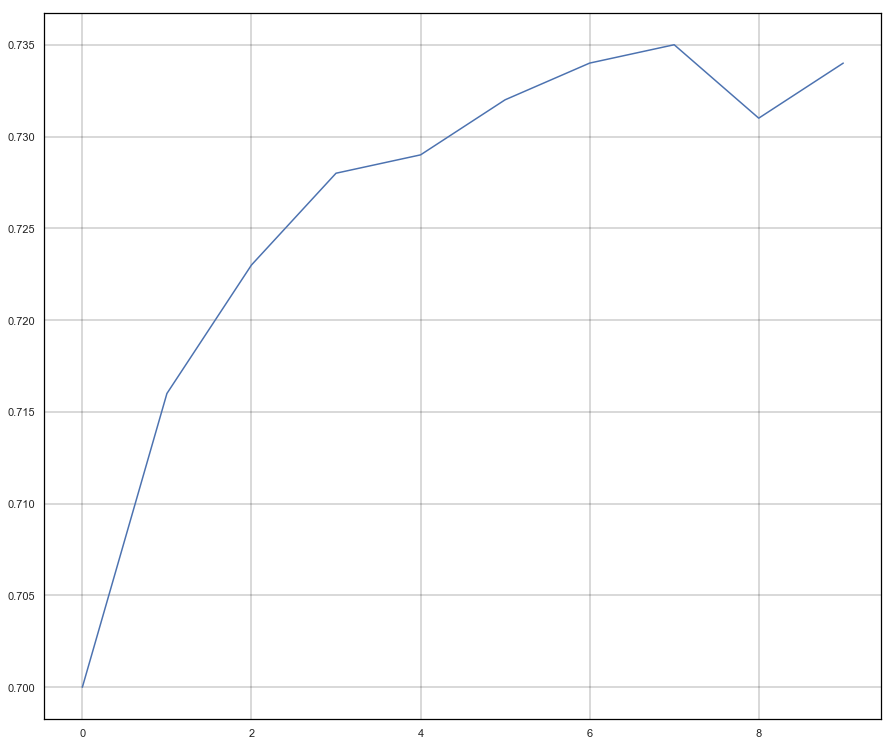

In [14]:
fig, axes = plt.subplots(nrows=1,figsize=(15,13), frameon=False)
p = axes.plot(seqs)
color_axes(axes)

fig.savefig('seq_lengths.svg',quality=95,dpi=200, format='svg')

In [98]:
# cross val results:
general_evaluation = {
        'fold0':0.72938126,
        'fold1':0.72858906,
        'fold2':0.72914827,
        'fold3':0.7381668,
        'fold4':0.6931991
    }


rew_ob_evaluation = {
         'fold0':0.702911,
         'fold1':0.7017816,
         'fold2':0.7000927,
         'fold3':0.71359944,
         'fold4':0.6662499
    }

In [106]:
labels = ['fold0', 'fold1', 'fold3', 'fold4', 'fold5']
general_res = [0.72938126, 0.72858906, 0.72914827,0.7381668,0.6931991]
rew_ob_res = [0.702911, 0.7017816, 0.7000927, 0.71359944,0.6662499]

In [107]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

In [100]:
eval_list = []

In [101]:
eval_list.append(pd.DataFrame.from_dict(general_evaluation, orient='index', columns = ['general']).T)
eval_list.append(pd.DataFrame.from_dict(rew_ob_evaluation, orient='index', columns = ['reward oblivious']).T)

In [102]:
eval_df = pd.concat(eval_list)

In [103]:
eval_df.T['general']

fold0    0.729381
fold1    0.728589
fold2    0.729148
fold3    0.738167
fold4    0.693199
Name: general, dtype: float64

In [119]:
fig, axes = plt.subplots(nrows=1,figsize=(15,13), frameon=False)
rects1 = axes.bar(x - width/2, general_res, width, label='General')
rects2 = axes.bar(x + width/2, rew_ob_res, width, label='Reward-Oblivious')
axes.set_yticks(np.arange(0.6,0.75, 0.025))
plt.ylim([0.65, 0.75])

color_axes(axes)

fig.savefig('cross_validation.svg',quality=95,dpi=200, format='svg')

In [115]:
np.arange(0.6,0.75, 0.025)

array([0.6  , 0.625, 0.65 , 0.675, 0.7  , 0.725, 0.75 ])

<a id='feb'></a>
# Feb 2022

adding 2 new graphs:
    1.  line graph with the probability of the certain choice - actual vs prediction of each model
    2.  trial-by-trial choices of a participant (one line indicating the choice - 1,2,3,4 on each trial), and the same graph but with the trial-by-trial predictions of the model for this participant    

# relevant vars:


[actual choices:](#actual_choices_distribution_plots)    
choices_prob2    
choices_prob3    
choices_prob4    
choices_prob2_df2    
choices_prob3_df3   
choices_prob3_df4    

lstms results:    
general_folds_results    
no_reward_folds_results

[reward-oriented - qlearning:](#load_reward_oriented)   
qlearning_payoff_2_person_predictions  
qlearning_payoff_3_person_predictions  
qlearning_payoff_4_person_predictions  

    

user_ids2    
user_ids3    
user_ids4    

to get the predictions I need to map the folds back to their original users (as done in averaging kfolds - CrossVal - producing true_false_predictions notebook)

In [28]:
general_dir = 'cross_validation/general_model/'
filename = 'general_model_results_5folds.pkl'
with open(os.path.join(general_dir,filename), 'rb') as f:
    general_folds_results = pickle.load(f)
    
# general_persons_true_false_predictions, general_persons_predictions_expr,\
#     general_total_actual_predictions, general_total_predicted_correct, general_persons_activations = general_folds_results[0]

no_reward_dir = 'cross_validation/no_reward_model/'
filename = 'no_reward_model_results_5folds.pkl'
with open(os.path.join(no_reward_dir,filename), 'rb') as f:
    no_reward_folds_results = pickle.load(f)
# no_reward_persons_true_false_predictions, no_reward_persons_predictions_expr, no_reward_total_actual_predictions, no_reward_total_predicted_correct = no_reward_results

In [34]:
def produce_predictions_correct_order(payoff2_test_participants_5fold_list, payoff3_test_participants_5fold_list, payoff4_test_participants_5fold_list, model_folds_results):
    folded_tests_sets = []
    dfs = []
    for test_2, test_3, test_4, results in zip(payoff2_test_participants_5fold_list, payoff3_test_participants_5fold_list, payoff4_test_participants_5fold_list, model_folds_results):
        fold_set = [*test_2 , *test_3 , *test_4]
        folded_tests_sets.append(fold_set)
        pars_true_false_predictions, pars_predictions_expr,\
        total_actual_predictions, total_predicted_correct, pars_activations = results

        cur_df = pd.DataFrame(pars_predictions_expr, index=fold_set)

        dfs.append(cur_df)
        
    return pd.concat(dfs).sort_index().to_numpy()

In [40]:
general_predictions = produce_predictions_correct_order(payoff2_test_participants_5fold_list, payoff3_test_participants_5fold_list, payoff4_test_participants_5fold_list, general_folds_results)
nr_predictions = produce_predictions_correct_order(payoff2_test_participants_5fold_list, payoff3_test_participants_5fold_list, payoff4_test_participants_5fold_list, no_reward_folds_results)

In [43]:
qlearning_predictions = []
qlearning_predictions.extend(qlearning_payoff_2_person_predictions)
qlearning_predictions.extend(qlearning_payoff_3_person_predictions)
qlearning_predictions.extend(qlearning_payoff_4_person_predictions)

In [50]:
# with open('general_model_predictions.pkl', 'wb') as h:
#     pickle.dump(general_predictions, h)
    
# with open('no_reward_model_predictions.pkl', 'wb') as h:
#     pickle.dump(nr_predictions, h)
    
# with open('qlearning_model_predictions.pkl', 'wb') as h:
#     pickle.dump(np.array(qlearning_predictions), h)

divide general and no-reward to payoffs

In [205]:
general_predictions_payoff2 = general_predictions[user_ids2-1].copy()
general_predictions_payoff3 = general_predictions[user_ids3-1].copy()
general_predictions_payoff4 = general_predictions[user_ids4-1].copy()

nr_predictions_payoff2 = nr_predictions[user_ids2-1].copy()
nr_predictions_payoff3 = nr_predictions[user_ids3-1].copy()
nr_predictions_payoff4 = nr_predictions[user_ids4-1].copy()

In [206]:
data_filled_NA['adjusted_user'] = data_filled_NA.user-1

In [207]:
data_payoff2 = data_filled_NA[data_filled_NA['payoff_structure']==2].copy()
data_payoff3 = data_filled_NA[data_filled_NA['payoff_structure']==3].copy()
data_payoff4 = data_filled_NA[data_filled_NA['payoff_structure']==4].copy()

In [208]:
# if we want to load accuracies to get the 5 most accuracte predicted users (instead of random) - use this 
general_all_folds_lstm_accs, general_payoff2_lstm_accs, general_payoff3_lstm_accs, general_payoff4_lstm_accs = general_all_accuracy_per_par
no_reward_all_folds_lstm_accs, no_reward_payoff2_lstm_accs, no_reward_payoff3_lstm_accs, no_reward_payoff4_lstm_accs = no_reward_all_accuracy_per_par

Predictions vs choices

picking completely at random can lead to users with too little actual choices... 
So, pick at random from the group of user who had at lead 90% actual choices

In [211]:
# create some metadata on the user

def get_users_metadata(payoff_df):

    users_percentage_choose = {}
    for user in payoff_df.adjusted_user.unique():
        cur_df = payoff_df[payoff_df['adjusted_user']==user].copy()
        unique, counts = np.unique(cur_df.choice, return_counts=True)
        total_choice = 0
        if -1 not in unique:
            total_choices = np.sum(counts)
        else:
            total_choices = np.sum(counts[1:])
        percentage_choose = total_choices/150
        users_percentage_choose[user] = percentage_choose
        
    return users_percentage_choose


In [212]:
users_perc_choosen_payoff2 = get_users_metadata(data_payoff2)
users_perc_choosen_payoff3 = get_users_metadata(data_payoff3)
users_perc_choosen_payoff4 = get_users_metadata(data_payoff4)

In [213]:
# go over each of the % choosen and remove ones with less than 90%

def remove_low_choice_count_users(users_perc_choosen_dict):
    for key in list(users_perc_choosen_dict.keys()):
        if users_perc_choosen_dict[key] < 0.9:
            del users_perc_choosen_dict[key]
            

In [214]:
remove_low_choice_count_users(users_perc_choosen_payoff2)
remove_low_choice_count_users(users_perc_choosen_payoff3)
remove_low_choice_count_users(users_perc_choosen_payoff4)

In [215]:
# offset, to map each user to range of 0-len(payoff)
payoff2_offset = 0
payoff3_offset = len(user_ids2)
payoff4_offset = len(user_ids2) + len(user_ids3)

In [216]:
random.seed(3)
# choose 5 random users from each payoff
payoff2_random_users = random.choices(np.array(list(users_perc_choosen_payoff2.keys())) - payoff2_offset, k=5)
payoff3_random_users = random.choices(np.array(list(users_perc_choosen_payoff3.keys())) - payoff3_offset, k=5)
payoff4_random_users = random.choices(np.array(list(users_perc_choosen_payoff4.keys())) - payoff4_offset, k=5)

In [217]:
# filter to their dataframes only
payoff2_random_users_df = data_payoff2[data_payoff2['adjusted_user'].isin(payoff2_random_users)].copy()
payoff3_random_users_df = data_payoff3[data_payoff3['adjusted_user'].isin(np.array(payoff3_random_users) + payoff3_offset)].copy()
payoff4_random_users_df = data_payoff4[data_payoff4['adjusted_user'].isin(np.array(payoff4_random_users) + payoff4_offset)].copy()

In [218]:
# filter to their predictions only
general_predictions_payoff2_random_users = general_predictions_payoff2[payoff2_random_users]
general_predictions_payoff3_random_users = general_predictions_payoff3[payoff3_random_users]
general_predictions_payoff4_random_users = general_predictions_payoff4[payoff4_random_users]

nr_predictions_payoff2_random_users = nr_predictions_payoff2[payoff2_random_users]
nr_predictions_payoff3_random_users = nr_predictions_payoff2[payoff3_random_users]
nr_predictions_payoff4_random_users = nr_predictions_payoff2[payoff4_random_users]


qlearning_payoff_2_person_predictions_random_users = np.array(qlearning_payoff_2_person_predictions)[payoff2_random_users]
qlearning_payoff_3_person_predictions_random_users = np.array(qlearning_payoff_3_person_predictions)[payoff3_random_users]
qlearning_payoff_4_person_predictions_random_users = np.array(qlearning_payoff_4_person_predictions)[payoff4_random_users]


In [277]:
def create_preds_vs_choices(gen_predictions, nr_predictions, qlearn_predictions, random_users_list, random_users_df, payoff, offset):
    random_users = np.array(random_users_list) + offset
    for i in range(5):
         
        fig, axes = plt.subplots(nrows=2,figsize=(15,13), sharex=True,frameon=False)
        x = [i for i in range(0,150)]
        p0 = axes[0].plot(x, gen_predictions[i], label='general') 
        p0 = axes[0].plot(x, nr_predictions[i], label='no-reward')
        p0 = axes[0].plot(x, qlearn_predictions[i], label='qlearning') 
        color_axes(axes[0])
        axes[0].set_ylabel('Prediction')
        axes[0].legend()
        axes[0].set_title(f'Participant #{random_users[i]} predictions')
                
        p1 = axes[1].plot(x, random_users_df[random_users_df['adjusted_user']==random_users[i]].choice)  
        color_axes(axes[1])
        axes[1].set_ylabel('Choice')
        axes[1].set_title(f'Participant #{random_users[i]} choices')
        
        axs = axes.flatten()
        axs[0].set_title(f'A - Participant #{random_users[i]} predictions', fontsize=20, x=0)
        axs[1].set_title(f'B - Participant #{random_users[i]} choices', fontsize=20, x=0)

        fig.savefig(os.path.join(saving_dir,f'payoff{payoff}_user{random_users[i]}_predictions.svg'),quality=95,dpi=200, format='svg')


In [278]:
# needs to fix predictions to be 1-4, but keep the -1's
# use this: np.where(general_predictions_payoff2_random_users+1 == 0, -1, general_predictions_payoff2_random_users+1)

create_preds_vs_choices(gen_predictions=np.where(general_predictions_payoff2_random_users+1 == 0, -1, general_predictions_payoff2_random_users+1),
                        nr_predictions=np.where(nr_predictions_payoff2_random_users+1 == 0, -1, nr_predictions_payoff2_random_users+1),
                        qlearn_predictions=np.where(qlearning_payoff_2_person_predictions_random_users+1 == 0, -1, qlearning_payoff_2_person_predictions_random_users+1), 
                        random_users_list=payoff2_random_users,
                        random_users_df=payoff2_random_users_df,
                        payoff=2,
                        offset=0
                       )

create_preds_vs_choices(gen_predictions=np.where(general_predictions_payoff3_random_users+1 == 0, -1, general_predictions_payoff3_random_users+1),
                        nr_predictions=np.where(nr_predictions_payoff3_random_users+1 == 0, -1, nr_predictions_payoff3_random_users+1),
                        qlearn_predictions=np.where(qlearning_payoff_3_person_predictions_random_users+1 == 0, -1, qlearning_payoff_3_person_predictions_random_users+1), 
                        random_users_list=payoff3_random_users,
                        random_users_df=payoff3_random_users_df,
                        payoff=3,
                        offset=payoff3_offset
                       )

create_preds_vs_choices(gen_predictions=np.where(general_predictions_payoff3_random_users+1 == 0, -1, general_predictions_payoff3_random_users+1),
                        nr_predictions=np.where(nr_predictions_payoff3_random_users+1 == 0, -1, nr_predictions_payoff4_random_users+1),
                        qlearn_predictions=np.where(qlearning_payoff_4_person_predictions_random_users+1 == 0, -1, qlearning_payoff_4_person_predictions_random_users+1), 
                        random_users_list=payoff4_random_users,
                        random_users_df=payoff4_random_users_df,
                        payoff=4,
                        offset=payoff4_offset
                       )

In [ ]:
# for i in range(5):
#     fig, axes = plt.subplots(nrows=2,figsize=(15,13), sharex=True,frameon=False)
#     x = [i for i in range(0,150)]
#     # plt.figure(figsize=(12, 8))
#     p0 = axes[0].plot(x, general_predictions_payoff2_random_users[i], label='general') 
#     p0 = axes[0].plot(x, nr_predictions_payoff2_random_users[i], label='no-reward')
#     p0 = axes[0].plot(x, qlearning_payoff_2_person_predictions_random_users[i], label='qlearning') 
#     color_axes(axes[0])
#     axes[0].set_ylabel('Prediction')
#     axes[0].legend()
#     axes[0].set_title(f'Participant #{payoff2_random_users[i]} predictions')


#     p1 = axes[1].plot(x, payoff2_random_users_df[payoff2_random_users_df['adjusted_user']==payoff2_random_users[i]].choice)  
#     color_axes(axes[1])
#     axes[1].set_ylabel('Choice')
#     axes[1].set_title(f'Participant #{payoff2_random_users[i]} choices')


#     fig.savefig(os.path.join(saving_dir,f'user{payoff2_random_users[i]}_predictions.svg'),quality=95,dpi=200, format='svg')
# #     plt.show()

Probabilites in a certain trial compare

[for the g.t choices use data from here](#actual_choices_distribution_plots):

choices_prob2_df2          
choices_prob3_df3         
choices_prob3_df4    


general_predictions_payoff2    
general_predictions_payoff3    
general_predictions_payoff4    

nr_predictions_payoff2    
nr_predictions_payoff3    
nr_predictions_payoff4    

qlearning_payoff_2_person_predictions    
qlearning_payoff_3_person_predictions    
qlearning_payoff_4_person_predictions    

In [264]:
# calculate probs for predictions
def get_prediction_prob(actions_matrix):
    pred_probs = []
    for i in range(actions_matrix.shape[1]):
        zeros = 0
        ones = 0
        twos = 0
        threes = 0
        nonNA = 0
        for value in np.asarray(actions_matrix[:,i]):
            if value == 0:
                zeros +=1
                nonNA +=1
            elif value == 1:
                ones +=1
                nonNA +=1
            elif value == 2:
                twos +=1
                nonNA +=1
            elif value == 3:
                threes +=1
                nonNA +=1
        if nonNA==0:
            pred_probs.append((0,0,0,0))
        else:
            pred_probs.append((zeros/nonNA,ones/nonNA,twos/nonNA,threes/nonNA))
        
    return pred_probs

In [265]:
# General model
gen_preds_prob_payoff2 = get_prediction_prob(general_predictions_payoff2)
gen_preds_prob_payoff3 = get_prediction_prob(general_predictions_payoff3)
gen_preds_prob_payoff4 = get_prediction_prob(general_predictions_payoff4)


gen_preds_prob_payoff2_df2 = pd.DataFrame(gen_preds_prob_payoff2,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

gen_preds_prob_payoff3_df3 = pd.DataFrame(gen_preds_prob_payoff3,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

gen_preds_prob_payoff4_df4 = pd.DataFrame(gen_preds_prob_payoff4,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

In [267]:
# No-Reward model probs

nr_preds_prob_payoff2 = get_prediction_prob(nr_predictions_payoff2)
nr_preds_prob_payoff3 = get_prediction_prob(nr_predictions_payoff3)
nr_preds_prob_payoff4 = get_prediction_prob(nr_predictions_payoff4)


nr_preds_prob_payoff2_df2 = pd.DataFrame(nr_preds_prob_payoff2,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

nr_preds_prob_payoff3_df3 = pd.DataFrame(nr_preds_prob_payoff3,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

nr_preds_prob_payoff4_df4 = pd.DataFrame(nr_preds_prob_payoff4,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

In [270]:
#Qlearning model probs

ql_preds_prob_payoff2 = get_prediction_prob(np.array(qlearning_payoff_2_person_predictions))
ql_preds_prob_payoff3 = get_prediction_prob(np.array(qlearning_payoff_3_person_predictions))
ql_preds_prob_payoff4 = get_prediction_prob(np.array(qlearning_payoff_4_person_predictions))


ql_preds_prob_payoff2_df2 = pd.DataFrame(ql_preds_prob_payoff2,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

ql_preds_prob_payoff3_df3 = pd.DataFrame(ql_preds_prob_payoff3,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

ql_preds_prob_payoff4_df4 = pd.DataFrame(ql_preds_prob_payoff4,
                  index=[i for i in range(150)], columns=['choice_1','choice_2','choice_3','choice_4'])

In [282]:
payoff=2

fig, axes = plt.subplots(nrows=4,figsize=(15,13), sharex=True,frameon=False)
# fig.suptitle('payoff probability over trials',y=0.99,x=0.5, fontdict=my_font_dict)

x = np.arange(0,150)

# general
p0 = axes[0].plot(gen_preds_prob_payoff2_df2)
color_axes(axes[0])
axes[0].set_title('General model prediction Probability')
axes[0].set_ylabel('Probability')



# no-reward
p1 = axes[1].plot(nr_preds_prob_payoff2_df2)
color_axes(axes[1])
axes[1].set_title('No-Reward model prediction Probability')
axes[1].set_ylabel('Probability')


# qlearning
p2 = axes[2].plot(ql_preds_prob_payoff2)
color_axes(axes[2])
axes[2].set_title('Qlearning model prediction Probability')
axes[2].set_ylabel('Probability')

# g.t choices
p3 = axes[3].plot(choices_prob2_df2)
color_axes(axes[3])
axes[3].set_title('Actual choice Probability')
axes[3].set_ylabel('Probability')

axs = axes.flatten()
axs[0].set_title('A - General model prediction Probability', fontsize=20, x=0)
axs[1].set_title('B - No-Reward model prediction Probability', fontsize=20, x=0)
axs[2].set_title('C - Qlearning model prediction Probability', fontsize=20, x=0)
axs[3].set_title('D - Actual choice Probability', fontsize=20, x=0)

plt.xlabel("Trial")

fig.legend(list(df2.columns),bbox_to_anchor=(0.99,0.50))

fig.savefig(os.path.join(saving_dir,f'payoff{payoff}_preds_choice_probs.svg'),quality=95,dpi=200, format='svg')

In [283]:
payoff=3

fig, axes = plt.subplots(nrows=4,figsize=(15,13), sharex=True,frameon=False)
# fig.suptitle('payoff probability over trials',y=0.99,x=0.5, fontdict=my_font_dict)

x = np.arange(0,150)

# general
p0 = axes[0].plot(gen_preds_prob_payoff3_df3)
color_axes(axes[0])
axes[0].set_title('General model prediction Probability')
axes[0].set_ylabel('Probability')



# no-reward
p1 = axes[1].plot(nr_preds_prob_payoff3_df3)
color_axes(axes[1])
axes[1].set_title('No-Reward model prediction Probability')
axes[1].set_ylabel('Probability')


# qlearning
p2 = axes[2].plot(ql_preds_prob_payoff3)
color_axes(axes[2])
axes[2].set_title('Qlearning model prediction Probability')
axes[2].set_ylabel('Probability')

# g.t choices
p3 = axes[3].plot(choices_prob3_df3)
color_axes(axes[3])
axes[3].set_title('Actual choice Probability')
axes[3].set_ylabel('Probability')

axs = axes.flatten()
axs[0].set_title('A - General model prediction Probability', fontsize=20, x=0)
axs[1].set_title('B - No-Reward model prediction Probability', fontsize=20, x=0)
axs[2].set_title('C - Qlearning model prediction Probability', fontsize=20, x=0)
axs[3].set_title('D - Actual choice Probability', fontsize=20, x=0)

plt.xlabel("Trial")

fig.legend(list(df2.columns),bbox_to_anchor=(0.99,0.50))

fig.savefig(os.path.join(saving_dir,f'payoff{payoff}_preds_choice_probs.svg'),quality=95,dpi=200, format='svg')

In [284]:
payoff=4

fig, axes = plt.subplots(nrows=4,figsize=(15,13), sharex=True,frameon=False)
# fig.suptitle('payoff probability over trials',y=0.99,x=0.5, fontdict=my_font_dict)

x = np.arange(0,150)

# general
p0 = axes[0].plot(gen_preds_prob_payoff4_df4)
color_axes(axes[0])
axes[0].set_title('General model prediction Probability')
axes[0].set_ylabel('Probability')



# no-reward
p1 = axes[1].plot(nr_preds_prob_payoff4_df4)
color_axes(axes[1])
axes[1].set_title('No-Reward model prediction Probability')
axes[1].set_ylabel('Probability')
s

# qlearning
p2 = axes[2].plot(ql_preds_prob_payoff4)
color_axes(axes[2])
axes[2].set_title('Qlearning model prediction Probability')
axes[2].set_ylabel('Probability')

# g.t choices
p3 = axes[3].plot(choices_prob3_df4)
color_axes(axes[3])
axes[3].set_title('Actual choice Probability')
axes[3].set_ylabel('Probability')

axs = axes.flatten()
axs[0].set_title('A - General model prediction Probability', fontsize=20, x=0)
axs[1].set_title('B - No-Reward model prediction Probability', fontsize=20, x=0)
axs[2].set_title('C - Qlearning model prediction Probability', fontsize=20, x=0)
axs[3].set_title('D - Actual choice Probability', fontsize=20, x=0)

plt.xlabel("Trial")

fig.legend(list(df2.columns),bbox_to_anchor=(0.99,0.50))

fig.savefig(os.path.join(saving_dir,f'payoff{payoff}_preds_choice_probs.svg'),quality=95,dpi=200, format='svg')